# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 2

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['The Gay Anties']
['"Short Film",  "Romance Film",  "Family Film",  "Comedy",  "Animation"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
###
### Checking whats inside the arrays
###

print("The shape of the array representing titles is",titles.shape)
#print("Take a peak in the titles: \n",titles[:5])
print("The shape of the array representing categories is",categories.shape)
#print("Take a peak in the categories: \n",categories[:5])
print("The shape of the array representing catbins is",catbins.shape)
#print("Take a peak in the catbins: \n",catbins[:5])
print("The length of the list representing corpus is",len(corpus))
#print("Take a peak in the corpus: \n",corpus[:5])

The shape of the array representing titles is (5000, 1)
The shape of the array representing categories is (5000, 1)
The shape of the array representing catbins is (5000, 322)
The length of the list representing corpus is 5000


# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Σε πρώτο στάδιο εκτυπώνονται τυχαία διαφορετικές περιγραφές ταινιών για να γίνει μια πρώτη επισκόπηση των πιθανιών προβλημάτων, που θα πρέπει να αντιμετωπιστούν.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint 

def InCorpus_Checker(korpus, Number_of_Descri):
  #Let's check whats going on inside the corpus
  tuxaio_NOTsame = []
  for i in range(0,Number_of_Descri):
    tuxaio = randint(0,4999)
    if i == 0:
      print("We are cheking line number: "+str(tuxaio))
      print(korpus[tuxaio],"\n")
      tuxaio_NOTsame.append(tuxaio)
    else:
      for j in range(0,len(tuxaio_NOTsame)):
        if(tuxaio_NOTsame[j]==tuxaio):
          tuxaio = randint(0,4999)
      print("We are cheking line number: "+str(tuxaio))
      print(korpus[tuxaio],"\n")
      tuxaio_NOTsame.append(tuxaio)
  return None

def mikos_Checker(korpus,mikos_lexis,mikos_peri):
  #In order to check if there are any small sentences
  micro_sent_Counter = 0
  grammi_Checker = []
  grammi_Checker_helper = 0
  #In order to check if there are any small words
  micro_word_Counter = 0
  word_Checker = []
  micro_word_pos = []
  for line in corpus:
    lexi_Counter = 0
    grammi_Checker_helper+=1
    for lexi in line.split(" "):
      lexi_Counter+=1
      if(len(lexi)<mikos_lexis):
        micro_word_Counter+=1
        word_Checker.append(lexi)
        micro_word_pos.append(grammi_Checker_helper-1)
    if(lexi_Counter<mikos_peri):
      micro_sent_Counter+=1
      grammi_Checker.append(grammi_Checker_helper-1)

  print("There are "+str(micro_word_Counter)+" small words!")
  print("These small words are in the following desciptions",len(np.unique(micro_word_pos)))
  print("Some of the small words are:",word_Checker[:25])
  print("There are "+str(micro_sent_Counter)+" small sentences!")
  print("The small sentences are:",grammi_Checker)
  
  return word_Checker, grammi_Checker

In [ ]:
InCorpus_Checker(corpus,5)

We are cheking line number: 628
Veeran was born to the chieftain of Varanavasi, but the baby was born with an unlucky mark destined to bring doom to the state. Acting as per the dictates of the astrologer, baby is abandoned in the forest. A cobbler and his wife discover the baby in the forest, and bring him up as their son. Veeran grows up to be a brave and noble youth. He chances to save Bommi, the princess of Thottiyam from being drowned in the Cauvery. Bommi falls in love with him. Though Veeran doesn’t reciprocate initially, he perceives the depth of her love gradually after Bommi comes riding on an elephant dressed as a man and saves Veeran from being trampled to death. Bommi’s uncle, the cowardly Narasappan finds his schemes of marrying Bommi falling apart. Citing Veeran’s low birth, Narasappan causes the lovers undue hardships. Due to opposition from Bommi's father, Veeran arrives and carries the princess away. Finally the King of Tiruchi, from whom Narasappan had sought assista

Σε αυτό το σημείο υλοποίηθηκε μια απλή αναζήτηση στο corpus. Τα τυχαία αποτελέσματα που προκύπτουν κάθε φορά δείχνουν ότι η πρώτη λέξη ξεκινάει πάντα με κεφαλαίο γράμμα, ενώ παράλληλα υπάρχουν διάφορα σημεία στίξης, όπως κόμματα, τελείες, παρενθέσεις, αγκύλες κτλ.<br>
Επιπλέον, η αναζήτηση που έγινε για την εύρεση συμβολοσειρών μικρού μήκους έδειξε ότι υπάρχουν πολλές συμβολοσειρές μήκους μέχρι τριών χαρακτήρων, συγκεκριμένα 620468, πολλές από τις οποίες δεν δίνουν κάποια σημασιολογική διαφορά στην περιγραφή της ταινίας, μιας και οι περισσότερες είναι άρθρα, αντωνυμίες και σημεία στίξης. Σε αυτές τις τρισύλλαβες λέξεις όμως ανηκούν και λέξεις, όπως not, οι οποίες είναι χρήσιμο να διατηρηθούν.

In [ ]:
#if 2nd argument == 2 -> 1letter
#if 2nd argument == 3 -> 2letters
#if 2nd argument == 4 -> 3letters
micro_lexeis, micro_perigrafes = mikos_Checker(corpus,3,15)

There are 293110 small words!
These small words are in the following desciptions 4998
Some of the small words are: ['up', 'is', 'a', 'is', 'to', 'up', 'to', 'a', 'is', 'on', ',', 'a', 'of', 'a', 'a', 'a', 'In', 'no', 'at', 'in', 'to', 'a', 'in', '.', 'on']
There are 5 small sentences!
The small sentences are: [945, 2532, 2920, 3098, 4329]


Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.


Άρα, σε αυτό το σημείο υλοποιούνται οι συναρτήσεις που θα χρησιμοποιηθούν έπειτα για την επεξεργασία του corpus. 

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_default = stopwords.words('english')
#print(stopwords_default)

#get the unique small words from before 
small_words = np.unique(micro_lexeis)
def findStopWords(mLexeis, stopWords):
  apotixies = []
  for mLexi in mLexeis:
    kriths = False
    for stopLexi in stopWords:
      if(mLexi == stopLexi):
        kriths = True
    if(not kriths):
      apotixies.append(mLexi)

  return apotixies

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
not_IN_stop = findStopWords(small_words, stopwords_default)
print(len(stopwords_default))
print(len(small_words))
#print(len(micro_lexeis))
print(len(not_IN_stop))

179
618
590


In [ ]:
#find some other stop words
import nltk
from nltk import word_tokenize
nltk.download('punkt')

corpus_tokens1 = []
for descri in corpus:
  corpus_tokens1.append(word_tokenize(descri))
  


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(corpus_tokens1[3987][24:50])
#possibly Dr.
contractions_out = ["n't", "'ve", "'m", "'re", "ca", "'s"]

['and', 'the', 'wealth', 'of', 'black', 'humor', 'also', 'including', 'Chow', "'s", 'signature', 'nonsense', 'jokes', '.', 'The', 'film', 'was', 'directed', 'by', 'Hong', 'Kong', "'s", 'Jeffrey', 'Lau', '.', 'Stephen']


In [ ]:
import string
stopwords_aug = np.concatenate((stopwords_default,not_IN_stop,contractions_out, list(string.punctuation)))

print(stopwords_aug.shape)
stopwords_aug = stopwords_aug.tolist()
print(len(stopwords_aug))

(807,)
807


In [ ]:
# func to do extra filtering than just blocked words
def thorough_filter(words):
    filtered_words = []
    
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words
        


In [ ]:
################## 
### Lem & Stem ###
##################

nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()


def Lem_Stem(description, kritis):
  
  edited_description = []
  #choose Lem or Stem
  if(kritis == 'Lem'):
    for lexi in description:
      Lem_lexi = wordnet_lemmatizer.lemmatize(lexi)
      edited_description.append(Lem_lexi)
  if(kritis == 'Stem'):
    for lexi in description:
      Stem_lexi = porter_stemmer.stem(lexi)
      edited_description.append(Stem_lexi)
    
  return edited_description



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
## checking how stem and lem works
games = ['playing','plays','player','play','played']
games_Lem = Lem_Stem(games, 'Lem')
games_Stem = Lem_Stem(games, 'Stem')
print(games_Lem)
print(games_Stem)

['playing', 'play', 'player', 'play', 'played']
['play', 'play', 'player', 'play', 'play']


Σε αυτό το σημείο θα γίνει η προεπεξεργασία του δοθέντος corpus σύμφωνα με τις συναρτήσεις που υλοποιήθηκαν. Πρέπει να σημειωθεί ότι την προεπεξεργασία του corpus την υλοποιήσαμε με δύο τρόπους, οι οποίοι διαφέρουν στην σειρά εκτέλεσης των βημάτων προεπεξεργασίας

In [ ]:
###############################
### prepocessing using nltk ###
###############################

import re
import sys
import collections
import nltk
#nltk.download('punkt') # necessary for tokenizer
#from autocorrect import Speller #needs !pip install autocorrect

from nltk import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords') 
import string

nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()


########################################
### The following Functions help us  ###
### preprocess our corpus using nltk ###
########################################
## https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/#i_Lowercasing

def preprocess_Applier(korpus, blocked_Words, kritis, thres_low, thres_high):
  
  #1st : Tokenize Corpus
  corpus_tokens = []
  for descri in korpus:
    corpus_tokens.append(word_tokenize(descri))
  
  #print(len(corpus_tokens))
  #print(corpus_tokens[0])
  
  #2nd : Lower and Stopwords
  filtered_words_medium = []
  for words in corpus_tokens:
    filtered_words_medium.append([word.lower() for word in words if word.lower() not in blocked_Words + list(string.punctuation)])

  #print(len(filtered_words_medium))
  #print(filtered_words_medium[0])

  filtered_words = []
  for filtro in filtered_words_medium:
    filtered_words.append(thorough_filter([word for word in filtro]))
  
  #print(len(filtered_words))
  #print(filtered_words[0])

  #3rd : Stem or Lem 
  cutter_words = []
  for lw in filtered_words:
    cutter_words.append(Lem_Stem(lw, kritis))

  #print(len(cutter_words))
  #print(cutter_words[0])


  #4th : Frequent words 
  freq_per_word = []
  for perig in cutter_words:
    freq_per_word.append(collections.Counter(perig))
  
  #print(len(freq_per_word))
  #print(freq_per_word[0])

  #5th : Cut the Frequent words
  total_counter = freq_per_word[0]

  for i in range(1,len(freq_per_word)):
    # counter with all the summaries
    total_counter += freq_per_word[i] 

  #print(total_counter, '\n')

  # keep only the words with a certain apperance frequency
  vocabulary = [word for word in total_counter if ((total_counter[word] > thres_low) and (total_counter[word] < thres_high))]
                                                       
  #print(vocabulary)
  
  return cutter_words, vocabulary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
#preprocess the corpus
%time preprocessed_corpus, vocabulary_corpus = preprocess_Applier(corpus, stopwords_aug, "Lem", 3, 50)

CPU times: user 1min, sys: 625 ms, total: 1min
Wall time: 1min 1s


In [ ]:
#Check if preprocessed_corpus OK ?
print("The total length of the preprocessed corpus is : ",len(preprocessed_corpus))
print("The total length of the 1st description of the preprocessed corpus is : ",len(preprocessed_corpus[0]))
print("The 1st description of the corpus is : \n",corpus[0])
print("The 1st description of the preprocessed corpus is : \n",preprocessed_corpus[0])

The total length of the preprocessed corpus is :  5000
The total length of the 1st description of the preprocessed corpus is :  57
The 1st description of the corpus is : 
 Betty wakes up after the morning after her birthday party. The house is a shambles, and Betty is not looking forward to cleaning up. She sings the title song while struggling with her chores. Grampy shows up to take Betty out for a drive, but Betty can't leave until everything is tidy. Grampy literally puts on his thinking cap , and invents a host of labor-saving devices: a cuckoo clock powered dishwasher, a combination bicycle and floor scrubber, and a player piano that folds laundry. In no time at all, the dancing inventor has the house spic and span, just in time to take Betty for a spin in his automobile .
The 1st description of the preprocessed corpus is : 
 ['betty', 'wake', 'morning', 'birthday', 'party', 'house', 'shamble', 'betty', 'looking', 'forward', 'cleaning', 'sings', 'title', 'song', 'struggling', 'ch

In [ ]:
#Check if vocabulary_corpus OK ?
print("The total length of the preprocessed corpus is : ",len(vocabulary_corpus))
print("The total length of the 1st word of the preprocessed corpus is : ",len(vocabulary_corpus[0]))
print("The 1st description of the corpus is : \n",corpus[0])
print("The 1st description of the preprocessed corpus is : \n",vocabulary_corpus[:61])

The total length of the preprocessed corpus is :  16115
The total length of the 1st word of the preprocessed corpus is :  7
The 1st description of the corpus is : 
 Betty wakes up after the morning after her birthday party. The house is a shambles, and Betty is not looking forward to cleaning up. She sings the title song while struggling with her chores. Grampy shows up to take Betty out for a drive, but Betty can't leave until everything is tidy. Grampy literally puts on his thinking cap , and invents a host of labor-saving devices: a cuckoo clock powered dishwasher, a combination bicycle and floor scrubber, and a player piano that folds laundry. In no time at all, the dancing inventor has the house spic and span, just in time to take Betty for a spin in his automobile .
The 1st description of the preprocessed corpus is : 
 ['shamble', 'cleaning', 'chore', 'tidy', 'cap', 'invents', 'powered', 'dishwasher', 'combination', 'bicycle', 'fold', 'laundry', 'inventor', 'span', 'spin', 'autom

In [ ]:
##########################
### process 2nd method ###
##########################

nltk.download('wordnet')
nltk.download('rslp')
nltk.download('punkt')
def preprocess(corpus):
  preprocessed_corp_joined=[]
  preprocessed_corp=[]
  i=0
  smallW=[]
  for description in corpus:
    tokenize=word_tokenize(description.lower())
    stem=[]
    for word in tokenize:
      porter_stemmer = PorterStemmer()
      stemmed_words = porter_stemmer.stem(word)
      stem.append(stemmed_words)
    filtered=thorough_filter(stem)
    preprocessed_corp.append(filtered)
    sentence=" ".join(filtered)
    preprocessed_corp_joined.append(sentence)
    for i in filtered:
      if len(i)<4:
        smallW.append(i)
  
  return preprocessed_corp_joined,smallW,preprocessed_corp



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
%time my_corp, small, my_corp_unjoined=preprocess(corpus)

CPU times: user 1min 2s, sys: 301 ms, total: 1min 2s
Wall time: 1min 5s


In [ ]:
#define the stopwords
all_stopwords=np.concatenate((stopwords_default,small,list(string.punctuation)))
stopwords=np.unique(all_stopwords)
stopwords=stopwords.tolist()

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create sparse tf_idf representation
vectorizer_simple = TfidfVectorizer()
vocab_tf_idf_simple = vectorizer_simple.fit(corpus)
corpus_tf_idf_simple = vectorizer_simple.transform(corpus)
print("The length of the corpus after tf-idf is:",corpus_tf_idf_simple.shape)
print("The length vocabulary of the corpus after tf-idf is:",len(vocab_tf_idf_simple.vocabulary_.values()))

The length of the corpus after tf-idf is: (5000, 48863)
The length vocabulary of the corpus after tf-idf is: 48863


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## create sparse tf_idf representation with preprocessed_corpus

#declaring the tfidf
vectorizer = TfidfVectorizer(max_df=200, min_df=10 ,analyzer='word', stop_words = stopwords)  

vocab_tf_idf = vectorizer.fit(my_corp)
prep_corpus_tf_idf = vectorizer.transform(my_corp).toarray()
print("The length of the corpus after tf-idf is:",prep_corpus_tf_idf.shape)
print("The length vocabulary of the corpus after tf-idf is:",len(vocab_tf_idf.vocabulary_.values()))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['58', '77', '83', 'eh', 'sr'] not in stop_words.
  % sorted(inconsistent)


The length of the corpus after tf-idf is: (5000, 5142)
The length vocabulary of the corpus after tf-idf is: 5142


In [ ]:
for i in range(0,len(prep_corpus_tf_idf)):
  if(sum(prep_corpus_tf_idf[i])==0):
    print("Make a less progressive cut off in the dictionary")
    print("Not a single word occured in "+str(i))

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
import scipy as sp

def diaxorisi():
  print("*-------------------------------------------------*",
        "*-------------------------------------------------*",
        "*-------------------------------------------------*")
       
  return None

def double_diaxorisi():
  print("*-------------------------------------------------*",
        "*-------------------------------------------------*",
        "*-------------------------------------------------*")
  print("*-------------------------------------------------*",
        "*-------------------------------------------------*",
        "*-------------------------------------------------*")
       
  return None

def Characteristics_Printer(idi):
  print("The movie's ID is: "+str(idi))
  print("The movie's title is: "+str(titles[idi]))
  print("The movie's summary is: "+str((summaries[idi])))
  print("The movie's categories are: "+str((categories[idi])))
  print(" ")
  return None

"""
  # Func content_recommender 
  # target_movie --> ID (int)
  # max_recommendations --> num recommendations (int)
  # corpus_type --> corpus in TF-IDF (ndarray)
"""

def content_recommender(target_movie, max_recommendations, corpus_type):

  #print id, title, summary, categories of target movie
  Characteristics_Printer(target_movie)

  #calculate the cosine similarity between all movies
  cosine_similarity = []
  for i in range(0,len(corpus_type)):
    if sum(corpus_type[i])!=0:
      cs_helper = sp.spatial.distance.cosine(corpus_type[target_movie], corpus_type[i])
      cosine_similarity.append(1-cs_helper)
  
  #sort list from lower to higher
  cs_lower2high = np.argsort(cosine_similarity)
  cs_high2lower = cs_lower2high[::-1]    
  

  # drop the first item because it is the cosine simularity with itself
  recommendations = cs_high2lower[1:max_recommendations+1]
  print("the movie recommendations are : \n")
  for recom in recommendations: 
    if (recom == target_movie):
      print("We run into the target movie again")
    else:
      #print id, title, summary, categories of recommendation movie
      print("The similarity with the target movie is:"+str(cosine_similarity[recom]))
      Characteristics_Printer(recom)
      diaxorisi()
      #continue
      

  return recommendations, cs_high2lower
   

In [ ]:
content_recommender(2069, 3, prep_corpus_tf_idf)

The movie's ID is: 2069
The movie's title is: ['Palletoori Pilla']
The movie's summary is: ["Shanta  is a beautiful village girl . Her neighbour Vasanth  loves her without her knowledge. Kampanna Dora  frequently raids over the villages and loots the inhabitants. Jayanth  is his main associate. One day Jayanth attacks the village, wherein Shanta lives. While robbing the people, Shanta slaps him and argues convincingly how bad his way of life affects their livelihood. This incident changes him and makes him leave his association with Kampanna. He lives with the villagers and trains the youth in fighting skills. Gradually Jayanth and Shanta loves each other. Unable to tolerate this Jayanth and Vasanth had a fight. When Shanta expresses her love for Jayanth, Vasanth accepts it and get them married. The angry Kampanna attacks the village to destroy them. Jayanth and his child were taken away. Shanta suspects Vasanth's involvement. Then Vasant goes to the hub of Kampanna and fights with the

(array([ 943, 3166, 1509]), array([2069,  943, 3166, ..., 3023, 3021,    0]))

In [ ]:
list1=[999,1080,4200,2700]
#print(np.sum(prep_corpus_tf_idf[0]))
for id in list1:
  double_diaxorisi()
  print('we have common categories \n')
  content_recommender(id, 3, prep_corpus_tf_idf)

*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*
*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*
we have common categories 

The movie's ID is: 999
The movie's title is: ['The Gay Anties']
The movie's summary is: ["A colony of ants surreptitiously invade a young couple's park picnic in the 1890s and contrive to steal their food. The gags include a scene in which the ants, frustrated three times in their efforts to make off with a sandwich, spread mustard on the back of the girlfriend's hand and trick the boyfriend into biting it, and one in which a female ant sings an overly melodramatic song  which gets the other ants to run for cover."]
The movie's categories are: ['"Short Film",  "Romance Film",  "Family Film",  "Comedy",  "Animation"']
 
the movie recommendations are : 


## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
!pip install -U gensim
#del list
import gensim
import gensim.downloader

print(gensim.downloader.info()['models'])
#checking what we can use
for model_name in list(gensim.downloader.info()['models'].keys()):
  print(model_name)

#print(list(gensim.downloader.info()['models'].keys()))

{'fasttext-wiki-news-subwords-300': {'num_records': 999999, 'file_size': 1005007116, 'base_dataset': 'Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)', 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py', 'license': 'https://creativecommons.org/licenses/by-sa/3.0/', 'parameters': {'dimension': 300}, 'description': '1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).', 'read_more': ['https://fasttext.cc/docs/en/english-vectors.html', 'https://arxiv.org/abs/1712.09405', 'https://arxiv.org/abs/1607.01759'], 'checksum': 'de2bb3a20c46ce65c9c131e1ad9a77af', 'file_name': 'fasttext-wiki-news-subwords-300.gz', 'parts': 1}, 'conceptnet-numberbatch-17-06-300': {'num_records': 1917247, 'file_size': 1225497562, 'base_dataset': 'ConceptNet, word2vec, GloVe, and OpenSubtitles 2016', 'reader_code': 'https://github.com/RaRe-Technologies/gen

Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


In [ ]:
import multiprocessing
import gensim
from gensim.models import Word2Vec
import joblib


In [ ]:
glove_twitter_25 = gensim.downloader.load('glove-twitter-25')
joblib.dump(glove_twitter_25, 'glove_twitter_25.pkl') 

['glove_twitter_25.pkl']

In [ ]:
glove_twitter_50 = gensim.downloader.load('glove-twitter-50')
joblib.dump(glove_twitter_50, 'glove_twitter_50.pkl') 

In [ ]:
glove_wiki_50 = gensim.downloader.load('glove-wiki-gigaword-50')
joblib.dump(glove_wiki_50, 'glove_wiki_50.pkl') 

In [ ]:
glove_wiki_100 = gensim.downloader.load('glove-wiki-gigaword-100')
joblib.dump(glove_wiki_100, 'glove_wiki_100.pkl') 

In [ ]:
## Load the plks needed
import multiprocessing
from gensim.models import Word2Vec
import joblib

"""

    ### choose your loaded ###

"""

#fasttext_300 = joblib.load('fasttext_300.pkl')
#conceptnet_300 = joblib.load('conceptnet_300.pkl')
#ruscorpora_300 = joblib.load('ruscorpora_300.pkl')
#google_300 = joblib.load('google_300.pkl')
#glove_wiki_50 = joblib.load('glove_wiki_50.pkl')
#glove_wiki_100 = joblib.load('glove_wiki_100.pkl')
#glove_wiki_200 = joblib.load('glove_wiki_200.pkl')
#glove_wiki_300 = joblib.load('glove_wiki_300.pkl')
glove_twitter_25 = joblib.load('glove_twitter_25.pkl')
#glove_twitter_50 = joblib.load('glove_twitter_50.pkl')
#glove_twitter_100 = joblib.load('glove_twitter_100.pkl')
#glove_twitter_200 = joblib.load('glove_twitter_200.pkl')


In [ ]:
model_twitter_50 = joblib.load('glove_twitter_50.pkl')
model_twitter_100 = joblib.load('glove_twitter_100.pkl')
model_wiki_50 = joblib.load('glove_wiki_50.pkl')
model_google_300 = joblib.load('word2vec_google_news_300.pkl')

 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

""" buid_tfw2v parameters
    # corpus          : preprocessed corpus
    # vectors         : model with embeddings
    # embeddings_size : dimensions of 

"""
  

def build_tfw2v_3(corpus, vectors, embeddings_size):
  """αρχικά φτιάχνω έναν πίνακα ο οποίος να περιέχει για κάθε περιγραφή ταινίας μόνο τις λέξεις που ανήκουν στο vocabulary"""
  
  final_corp=[]
  for sentence in corpus:
    help_array=[]
    for word in sentence:
      exists=word in stopwords
      exists1=vocab_tf_idf.vocabulary_.get(word)
      if exists1!=None:
        help_array.append(word)
    final_corp.append(np.unique(help_array)) #ως επιπλέον βήμα στην προεπεξεργασία θέλουμε κάθε λέξη να υπαρχει σε μία πειργραφή μόνο μία φορά
  #print('gucci')
  """στην συνέχεια φτιάχνουμε ένα ζεύγος πιν΄καων οι οποίοι περιέχουν για κάθε λέξη του vocabulary το αντίστοιχο διάνυσμα embeddings"""
  emb_val=[]
  emb_word=[]
  for word in list(vocab_tf_idf.vocabulary_.keys()):
    if word in vectors.index_to_key:
      emb_val.append(vectors[word][:embeddings_size])
      emb_word.append(word)
  #print('gucci')
  """τέλος κρατάμε την τομή των δύο παραπάνω πινάκων δηλαδή τις λέξεις οι οποίες ανήκουν στο vocabulary και παράλληλα έχουν διάνυσμα embediings"""
  last_corp=[]
  for sentence in final_corp:
    help=[]
    for word in sentence:
      exist =word in emb_word
      if exist==True:
        help.append(word)
    last_corp.append(help)
        
  


  #print('gucci')
  final=[]
  for i in range(len(last_corp)):
    print(i)
    sentence=last_corp[i]
    products_all=0
    tf_idf_counter=0
    for word in sentence:
      index=vocab_tf_idf.vocabulary_[word]
      tf_idf_val=prep_corpus_tf_idf[i][index]
      tf_idf_counter+=tf_idf_val
      indexing=emb_word.index(word)
      embeding_val=emb_val[indexing]
      product=tf_idf_val*embeding_val
      products_all+=product
    if tf_idf_counter!=0:
      final_val=products_all/(tf_idf_counter)
      final.append(final_val)
  return final
  

In [ ]:
%time final_w2v = build_tfw2v(my_corp_unjoined, glove_twitter_25, 24)

In [ ]:
#store them with joblib
joblib.dump(final_w2v, 'final_w2v.pkl')
final_w2v = joblib.load('final_w2v.pkl')

In [ ]:
content_recommender(999, 5, final_w2v)

The movie's ID is: 999
The movie's title is: ['The Gay Anties']
The movie's summary is: ["A colony of ants surreptitiously invade a young couple's park picnic in the 1890s and contrive to steal their food. The gags include a scene in which the ants, frustrated three times in their efforts to make off with a sandwich, spread mustard on the back of the girlfriend's hand and trick the boyfriend into biting it, and one in which a female ant sings an overly melodramatic song  which gets the other ants to run for cover."]
The movie's categories are: ['"Short Film",  "Romance Film",  "Family Film",  "Comedy",  "Animation"']
 
the movie recommendations are : 

The similarity with the target movie is:0.9618332982063293
The movie's ID is: 1025
The movie's title is: ['Pantry Panic']
The movie's summary is: ['Woody ([[Danny Webb  stays behind to swim while the other birds in the forest migrate south for the winter. Just after the other birds leave, the cold of winter sets in instantly, to the poin

(array([1025, 2140, 4084,  933,  928]),
 array([ 999, 1025, 2140, ..., 4324,  858, 2920]))

**Δοκιμές για διάφορα w2v**

In [ ]:
w2v_twitter_50=build_tfw2v_3(my_corp_unjoined, model_twitter_50,45)
ids=[999,1080,4200,2700]
for i in ids:
  content_recommender(i, 5, w2v_twitter_50)

In [ ]:
w2v_twitter_100=build_tfw2v_3(my_corp_unjoined, model_twitter_100,90)
for i in ids:
  content_recommender(i, 5, w2v_twitter_100)

In [ ]:
w2v_wiki_50=build_tfw2v_3(my_corp_unjoined, model_wiki_50,45)
for i in ids:
  content_recommender(i, 5, w2v_wiki_50)

In [ ]:
w2v_google_300=build_tfw2v_3(my_corp_unjoined, model_google_300,150)
for i in ids:
  content_recommender(i, 5, w2v_google_300)

**Συνολικά συμπεράσματα και παρατηρήσεις**. 
Αρχικά εφαρμόζουμε το movie_recomendation system βασιζόμενοι μόνο στον tf-idVectorizer, ενώ στην συνέχεια χρησιμοποιούμε τα pre_trained models που μας προσφέρει η βιβλιοθήκη gensim ούτως ώστε να χρησιμοποιήσουμε embeddings για τα keywords μας.

Στην αποκλειστική χρήση του tf-idVectorizer παρατηρούμε ότι το σύστημά μας λειτουργεί αρκετά αποδοτικά σε μικρό βάθος recomendations(2 εώς 3) ενώ για μεγαλύτερα βάθη οι προτάσεις που κάνει αποκλίνουν τόσο θεματικά, δηλαδή σπάνια εμφανίζουν κοινά categories με την αρχική ταινία-στόχο αλλά και οι τιμές του cosine_similarity αποκτούν πολύ μικρές τιμές. Αυτό συμβαίνει γιατί, το TF-IDF θεμελιώνεται σε ένα μοντέλο bag-of-words (BoW) και επομένως αδυνατεί να συμπεριλάβει στους υπολογισμούς του για την εκάστοτε λέξη την ακριβή σημασιολογία, τη θέση εντός της πρότασης και εμφανίσεις σε άλλα αρχεία.Συνεπώς, δε προτείνεται για τη συγκεκριμένη χρήση παρά μόνο για λεκτικής σημασίας χαρακτηριστικό.

Αντίθετα όταν χρησιμοποιούμε τα προεκπαιδευμένα μοντέλα της gensim τα recommendations που προκύπτουν είναι πολύ πιο αξιόπιστα. Αρχικά, παρατηρούμε ότι οι τιμές του cosine_similarity είναι σαφώς υψηλότερες, ενώ οι προτάσεις που προκύπτουν είναι ποιοτικά καλύτερες εφόσον θεματικά προσεγγίζουν καλύτερα την ταινία στόχο. Το τελευταίο παρατηρείται συνήθως σε προτάσεις μεγαλύτερου βάθους όπου τα μοντέλα της gensim εμφανίζουν πολύ πιο αποδοτική λειτουργία. Στα pretrained models παρουσιάζεται βελτιωμένη απόδοση εφόσον καθίσταται εφικτή η συντακτική και σημασιολογική (various syntactic and semantic) NLP διεργασία.
Βέβαια στις αρχικές προτάσεις (1η και 2η προταση) πολλές φορές τα recomendations είναι κοινά.

Παρόλα αυτά η gensim δίνει μία πληθώρα μοντέλων με διαφορετικό διάνυσμα embeddings σε πλήθος και τιμές. Τα training embeddings χρησιμοποιούνται για να μειώσουν τις διαστασεις του χωρου, τον οποίο επιχειρούμε να ταξινομήσουμε επιτυγχάνοντας με αυτόν τον τρόπο καλύτερες και ταχύτερες προβλέψεις. Προφανώς όσο καλύτερα προεκπαιδευμένα είναι ένα μοντέλο, δηλαδή έχει εκπαιδευτεί πάνω σε μεγαλύτερο dataset, τόσο καλύτερα recomendations θα αποδίδει. Εφαρμόσαμε, λοιπόν, διάφορα μοντέλα με διαφορετικό αριθμό embeddings και παρατηρήσαμε ότι όσο μεγαλύτερο πλήθος embeddings χρησιμοποιούμε τόσο κοντινότερες θεματικά προτάσεις παίρνουμε. Βέβαια παρατηρούμε και μία παράλληλη μείωση του cosine_similarity πράγμα που δεν μας προβληματίζει, καθώς δε θεμελιώνονται στην βελτιστοποίηση της cosine similarity, η οποία δυσχεραίνει με την αύξηση των embeddings καθώς ενδιαφερόμαστε για πεπερασμένο αριθμό λέξεων. Επιπλέον, εκτός από το πλήθος των embeddings που χρησιμοποιούνται, για την μειωμένη επίδοση ίσως να ευθύνεται η ποικιλόμορφη κατανομή των λέξεων στο corpus που συνυπάρχουν μαζί με ένα μεγάλο πλήθος λέξεων και με αυτόν τον τρόπο αυξάνεται η απόσταση μεταξύ παρόμοιων λέξεων (μείωνεται η cosine simlarity). 
Με βάση τη διαδικασία μάθησης των συγκεκριμένων vectors που ακολουθείται αντιλαμβάνονται τη σημασιολογία των λέξεων και ως εκ τούτου παρόμοιες λέξεις είναι κοντά στο λεγόμενο induced space (Soft Cosine Similarity). Η μέθοδος υπολογισμού της cosine similarity ουσιαστικά βασίζεται σε αυτή την σημασιολογική εγγύτητα καθώς θεωρούμε οτι παρόμοιες λέξεις συνδέονται όχι μόνο σημασιολογικά αλλά και με βάση το χώρο στον οποίο ανήκουν.


**Cherry-Picking**



In [ ]:
cherry_list = [999,1111,1080,2700,3701]
#print(np.sum(prep_corpus_tf_idf[0]))
for kerasi in cherry_list:
  double_diaxorisi()
  print('we have common categories \n')
  content_recommender(kerasi, 3, final_w2v)

*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*
*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*
we have common categories 

The movie's ID is: 1008
The movie's title is: ['Love Is My Profession']
The movie's summary is: ['Maitre André Gobillot , a distinguished lawyer in his mid 50s, successfully defends a beautiful young woman, Yvette Maudet , who has committed a robbery. In the process, he falls in love with her, putting his reputation and marriage at risk, but she is not true to him, and ends up being murdered by her jealous lover Mazzetti .']
The movie's categories are: ['"Crime Fiction",  "Romance Film",  "Drama"']
 
the movie recommendations are : 

The similarity with the target movie is:0.9183092713356018
The movie's ID is: 1054
The movie's title is: ['Illustrious C

**Nir-picking**

In [ ]:
nir_list = [130,4200,4075,2701,3001]
#print(np.sum(prep_corpus_tf_idf[0]))
for nir in nir_list:
  double_diaxorisi()
  print('we have common categories \n')
  content_recommender(nir, 3, final_w2v)

*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*
*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*
we have common categories 

The movie's ID is: 130
The movie's title is: ["Don't Lose Your Head"]
The movie's summary is: ["It is the time of the French Revolution, and two bored English noblemen, Sir Rodney Ffing  and his best friend, Lord Darcy Pue,  decide to have some fun and save their French counterparts from beheading by the guillotine. Enraged revolutionary leader Citizen Camembert  and his toadying lackey, Citizen Bidet , scour France and England for the elusive saviour of the French nobles, who has become known as The Black Fingernail. After abducting the Fingernail's true love, Jacqueline , Camembert and Bidet plot to lure the Fingernail to his death... oblivious that 

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nir-picking:](https://www.merriam-webster.com/dictionary/nit-picking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
import joblib
final_w2v = joblib.load('final_w2v.pkl')

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    #mycorpus2 = np.asarray(mycorpus)
    #dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
#final_set = build_final_set(prep_corpus_tf_idf)
final_set_prep = build_final_set(prep_corpus_tf_idf)

In [ ]:
print("The shape of the prep corpus tf idf is :",prep_corpus_tf_idf.shape)
print("The shape of the final set is :",final_set_prep.shape)
print("The shape of the catbins is :",catbins.shape)

The shape of the prep corpus tf idf is : (5000, 5142)
The shape of the final set is : (5000, 5464)
The shape of the catbins is : (5000, 322)


In [ ]:
def build_final_set_w2v(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    mycorpus2 = np.asarray(mycorpus)
    #dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    dense_tf_idf = mycorpus2[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
#final_set = build_final_set(prep_corpus_tf_idf)
final_set = build_final_set_w2v(final_w2v)

In [ ]:
print("The shape of the prep corpus tf idf is :",len(final_w2v))
print("The shape of the final set is :",final_set.shape)
print("The shape of the catbins is :",catbins.shape)

The shape of the prep corpus tf idf is : 5000
The shape of the final set is : (5000, 346)
The shape of the catbins is : (5000, 322)


## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu

In [ ]:
# install matplotlib
!pip install --upgrade numpy
!pip install --upgrade matplotlib

In [ ]:

# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [ ]:
###########################
### Chop Movies to 2000 ###
###########################

corpus_2000 = corpus[:2000][:]

print("The length of the new corpus is:"+str(len(corpus_2000)))

## check if OK ?
for i in range(0,len(corpus_2000)):
  if(len(corpus_2000[i])!=len(corpus[i])):
    print("Problem Occured!!")
    
my_corp_2000, small_2000, my_corp_unjoined_2000 = preprocess(corpus_2000)

The length of the new corpus is:2000


In [ ]:
#define the stopwords
all_stopwords_2000 = np.concatenate((stopwords_default,small_2000,list(string.punctuation)))
stopwords_2000 = np.unique(all_stopwords_2000)
stopwords_2000 = stopwords_2000.tolist()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

## create sparse tf_idf representation with preprocessed_corpus_2000

#declaring the tfidf
tf_idf_2000 = TfidfVectorizer(max_df=200, min_df=10 ,analyzer='word', stop_words = stopwords_2000)  

vocab_tf_idf_2000 = tf_idf_2000.fit(my_corp_2000)
prep_corpus_tf_idf_2000 = tf_idf_2000.transform(my_corp_2000).toarray()
print("The length of the corpus after tf-idf is:",len(prep_corpus_tf_idf_2000))
print("The length vocabulary of the corpus after tf-idf is:",len(vocab_tf_idf_2000.vocabulary_.values()))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eh', 'lt', 'sr'] not in stop_words.
  % sorted(inconsistent)


The length of the corpus after tf-idf is: 2000
The length vocabulary of the corpus after tf-idf is: 3056


In [ ]:
%time final_2000_w2v = build_tfw2v(my_corp_unjoined_2000, glove_twitter_25, 24)

In [ ]:
#store them with joblib
joblib.dump(final_2000_w2v, 'final_2000_w2v.pkl')
final_2000_w2v = joblib.load('final_2000_w2v.pkl')

In [ ]:
## combine corpus 2000 with catbins with build_final_set
final_set_2000_prep = build_final_set(prep_corpus_tf_idf_2000, doc_limit = 2000)

In [ ]:
## combine corpus 2000 with catbins with build_final_set
final_set_2000 = build_final_set_w2v(final_2000_w2v, doc_limit = 2000)

Σε αυτό το σήμειο έχει δημιουργηθεί μια αναπαράσταση ενός τμήματος του αρχικού corpus. Συγκεκριμένα, έχουν αποθηκευτεί οι 2000 πρώτες περιγραφές ταινιών και έχουν υποστεί προεπεξεργασία και με βάση αυτό το νέο προεπεξεργασμένο corpus 2000 περιγραφών έχει δημιουργηθεί η νέα tf-idf αναπαράσταση. 

**SOMOCLU και χάρτες SOM**

Σε αυτό το σημείο δημιουργούνται κλάσεις τύπου somoclu, με διαφορετικές διαστάσεις στο grid του χάρτη. Στην αρχή δοκιμάζεται το τμήμα των 2000 περιγραφών ταινιών για να προκύψει μια πρώτη επαφή με το χρόνο που απαιτείται για την εκπαίδευση κάθε κλάσης. 

In [ ]:
import joblib

""" ### SOM ### """
def somoclu_caller(setaki, columns, rows, epoxes):
  #just declaring the parameters in interest and leave the rest default
  somoklu = somoclu.Somoclu(n_columns=columns, n_rows=rows, maptype='planar')
  
  print("The time need to calculate is:")

  #train and calculate the time
  %time somoklu.train(setaki, epochs=epoxes)
  
  return somoklu

**Σύγκριση tf-idf και word2vector**

Πέρα από την εκπαίδευση της κάθε κλάσης της somoclu με όρισμα την word2vector υλοποίηση της, έγινε και εκπαίδευση κάθε κλάσης της somoclu με όρισμα την tf-idf.  

In [ ]:
""" ### SOM with 10x10 , 100 epochs , slice of movie 2000 ### """
somoclu_10_2000_prep = somoclu_caller(final_set_2000_prep, 10, 10, 100)

#store them with joblib
joblib.dump(somoclu_10_2000_prep, 'somoclu_10_2000_prep.pkl')
somoclu_10_2000_prep = joblib.load('somoclu_10_2000_prep.pkl') 

The time need to calculate is:
CPU times: user 3min 14s, sys: 886 ms, total: 3min 15s
Wall time: 1min 39s


In [ ]:
""" ### SOM with 10x10 , 100 epochs , slice of movie 2000 ### """
somoclu_10_2000 = somoclu_caller(final_set_2000, 10, 10, 100)

#store them with joblib
joblib.dump(somoclu_10_2000, 'somoclu_10_2000.pkl')
somoclu_10_2000 = joblib.load('somoclu_10_2000.pkl')

The time need to calculate is:
CPU times: user 21.4 s, sys: 95.8 ms, total: 21.5 s
Wall time: 12.9 s


In [ ]:
""" ### SOM with 20x20 , 100 epochs , slice of movie 2000 ### """
somoclu_20_2000 = somoclu_caller(final_set_2000, 20, 20, 100)

#store them with joblib
joblib.dump(somoclu_20_2000, 'somoclu_20_2000.pkl')
somoclu_20_2000 = joblib.load('somoclu_20_2000.pkl') 

The time need to calculate is:
CPU times: user 1min 24s, sys: 319 ms, total: 1min 24s
Wall time: 43.8 s


In [ ]:
""" ### SOM with 25x25 , 100 epochs , slice of movie 2000 ### """
somoclu_25_2000 = somoclu_caller(final_set_2000, 25, 25, 100)

#store them with joblib
joblib.dump(somoclu_25_2000, 'somoclu_25_2000.pkl')
somoclu_25_2000 = joblib.load('somoclu_25_2000.pkl') 

The time need to calculate is:
CPU times: user 2min 11s, sys: 500 ms, total: 2min 11s
Wall time: 1min 7s


In [ ]:
""" ### SOM with 30x30 , 100 epochs , slice of movie 2000 ### """
somoclu_30_2000 = somoclu_caller(final_set_2000, 30, 30, 100)

#store them with joblib
joblib.dump(somoclu_30_2000, 'somoclu_30_2000.pkl')
somoclu_30_2000 = joblib.load('somoclu_30_2000.pkl') 

The time need to calculate is:
CPU times: user 3min 10s, sys: 775 ms, total: 3min 10s
Wall time: 1min 37s


Απο αυτό το σημείο και έπειτα χρησιμοποιούνται όλες οι περιγραφές ταινιών, με αποτέλεσμα ο χρόνος που χρειάζεται η somoclu να αυξάνεται. Μάλιστα, από τις παραπάνω εκπαιδεύσεις των κλάσεων φαίνεται ότι όσο αυξάνεται το grid του χάρτη τόσο αυξάνεται ο χρόνος trainig που απαιτείται. Παρακάτω, λοιπόν, που ογκός των δεδομένων είναι μεγαλύτερος αναμένεται και ο χρόνος εκπαιδεύσης να είναι αναλογικά περισσότερος.  

**Για χάρτη SOM (10x10)**

In [ ]:
""" ### SOM with 10x10 , 100 epochs , all movies 5000 ### """
somoclu_10 = somoclu_caller(final_set, 10, 10, 100)

#store them with joblib
joblib.dump(somoclu_10, 'somoclu_10.pkl')
somoclu_10 = joblib.load('somoclu_10.pkl')

The time need to calculate is:
CPU times: user 53.5 s, sys: 259 ms, total: 53.8 s
Wall time: 30.4 s


**Για χάρτη SOM (20x20)**

In [ ]:
""" ### SOM with 20x20 , 100 epochs , all movies 5000 ### """
somoclu_20 = somoclu_caller(final_set, 20, 20, 100)

#store them with joblib
joblib.dump(somoclu_20, 'somoclu_20.pkl')
somoclu_20 = joblib.load('somoclu_20.pkl') 

The time need to calculate is:
CPU times: user 3min 32s, sys: 1.06 s, total: 3min 33s
Wall time: 2min 11s


**Για χάρτη SOM (25x25)**

In [ ]:
""" ### SOM with 25x25 , 100 epochs , all movies 5000 ### """
somoclu_25 = somoclu_caller(final_set, 25, 25, 100)

#store them with joblib
joblib.dump(somoclu_25, 'somoclu_25.pkl')
somoclu_25 = joblib.load('somoclu_25.pkl')

The time need to calculate is:
CPU times: user 5min 29s, sys: 1.34 s, total: 5min 30s
Wall time: 2min 49s


**Για χάρτη SOM (30x30)**

In [ ]:
""" ### SOM with 30x30 , 100 epochs , all movies 5000 ### """
somoclu_30 = somoclu_caller(final_set, 30, 30, 100)

#store them with joblib
joblib.dump(somoclu_30, 'somoclu_30.pkl')
somoclu_30 = joblib.load('somoclu_30.pkl')

The time need to calculate is:
CPU times: user 7min 55s, sys: 2.12 s, total: 7min 57s
Wall time: 4min 5s


**Συμπέρασμα Σύγκρισης tf-idf και word2vec**

Από τις παραπάνω εκπαιδεύσεις και σε σύγκριση με εκπαιδεύσεις που έγιναν, παρατηρήθηκε ότι η εκπαίδευση με αναπαράσταση με tf-idf είναι πολύ πιο χρονοβόρα απο την εκπαίδευση με word2vec. Μάλιστα, ως μη βέλτιση υλοποίηση του my_corpus, η απεικόνιση με umatrix αναμένεται να δώσει χειρότερα αποτελέσματα (όπως θα φανεί και πιο κάτω). 

In [ ]:
""" GET THE SOMOCLUs INSTA """
somoclu_10_2000 = joblib.load('somoclu_10_2000.pkl') 
somoclu_20_2000 = joblib.load('somoclu_20_2000.pkl') 
somoclu_25_2000 = joblib.load('somoclu_25_2000.pkl') 
somoclu_30_2000 = joblib.load('somoclu_30_2000.pkl')
somoclu_10 = joblib.load('somoclu_10.pkl') 
somoclu_20 = joblib.load('somoclu_20.pkl')
somoclu_25 = joblib.load('somoclu_25.pkl')
somoclu_30 = joblib.load('somoclu_30.pkl') 
somoclu_10_2 = joblib.load('somoclu_10_2.pkl') 


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
def BMUs_calculator(setaki, somocli):
  
  #bmus = somocli.get_bmus(setaki)
  bmus = somocli.bmus
  bmus_uniq, indices = np.unique(ar=bmus, return_inverse=True, axis=0)
  
  
  return bmus_uniq, indices

**Δοκιμές μεταξύ tf-idf και w2v**

In [ ]:
### tests between tf_idf and w2v
""" ### SOM with 10x10 , 100 epochs , slice of movie 2000 ### """
bmus_10_2000_prep, indices_10_2000_prep = BMUs_calculator(final_set_2000_prep, somoclu_10_2000_prep)

""" ### SOM with 10x10 , 100 epochs , slice of movie 2000 ### """
bmus_10_2000_w2v, indices_10_2000_w2v = BMUs_calculator(final_set_2000, somoclu_10_2000)

**Εύρεση BMUs για τμήμα ταινιών (2000)**

In [ ]:
""" ### SOM with 10x10 , 100 epochs , slice of movie 2000 ### """
bmus_10_2000, indices_10_2000 = BMUs_calculator(final_set_2000, somoclu_10_2000)

print("The shape of the bmus for SOM{(10x10),(100),(2000)} is:",bmus_10_2000.shape)
print("The shape of the indices for SOM{(10x10),(100),(2000)} is:",indices_10_2000.shape)
print("Let's take a peak inside the indices:",indices_10_2000[:25])

The shape of the bmus for SOM{(10x10),(100),(2000)} is: (100, 2)
The shape of the indices for SOM{(10x10),(100),(2000)} is: (2000,)
Let's take a peak inside the indices: [24 28 63 96  6 84  7 73 29 37 28  8 52 94 13 55 98 64 21 65 71 58 72 73
 19]


In [ ]:
""" ### SOM with 20x20 , 100 epochs , slice of movie 2000 ### """
bmus_20_2000, indices_20_2000 = BMUs_calculator(final_set_2000, somoclu_20_2000)

print("The shape of the bmus for SOM{(20x20),(100),(2000)} is:",bmus_20_2000.shape)
print("The shape of the indices for SOM{(20x20),(100),(2000)} is:",indices_20_2000.shape)
print("Let's take a peak inside the indices:",indices_20_2000[:25])

The shape of the bmus for SOM{(20x20),(100),(2000)} is: (392, 2)
The shape of the indices for SOM{(20x20),(100),(2000)} is: (2000,)
Let's take a peak inside the indices: [351 283 215 171 252 154 190 229 185 286 261 228  75   0 351 333 141 315
  80 275 175 356 136 200 203]


In [ ]:
""" ### SOM with 25x25 , 100 epochs , slice of movie 2000 ### """
bmus_25_2000, indices_25_2000 = BMUs_calculator(final_set_2000, somoclu_25_2000)

print("The shape of the bmus for SOM{(25x25),(100),(2000)} is:",bmus_25_2000.shape)
print("The shape of the indices for SOM{(25x25),(100),(2000)} is:",indices_25_2000.shape)
print("Let's take a peak inside the indices:",indices_25_2000[:25])

The shape of the bmus for SOM{(25x25),(100),(2000)} is: (599, 2)
The shape of the indices for SOM{(25x25),(100),(2000)} is: (2000,)
Let's take a peak inside the indices: [597 152 336 514 465 510 347 364 155 148 154 315 192 397 549 216  62 172
 504 245 430  75 431 364 183]


In [ ]:
""" ### SOM with 30x30 , 100 epochs , slice of movie 2000 ### """
bmus_30_2000, indices_30_2000 = BMUs_calculator(final_set_2000, somoclu_30_2000)

print("The shape of the bmus for SOM{(30x30),(100),(2000)} is:",bmus_30_2000.shape)
print("The shape of the indices for SOM{(30x30),(100),(2000)} is:",indices_30_2000.shape)
print("Let's take a peak inside the indices:",indices_30_2000[:25])

The shape of the bmus for SOM{(30x30),(100),(2000)} is: (792, 2)
The shape of the indices for SOM{(30x30),(100),(2000)} is: (2000,)
Let's take a peak inside the indices: [187 303  67 632 580 742 664 476 408 455 410 430 658 769  81 153 293 221
  85 271  12 285  11 447 350]


Απο αυτό το σημείο και έπειτα χρησιμοποιούνται όλες οι κλάσεις της somoclu για τις διάφορες διαστάσεις των πινάκων, που θα σχεδιαστούν.

**Εύρεση BMUs για όλες τις ταινίες (5000)**

In [ ]:
""" ### SOM with 10x10 , 100 epochs , all movies 5000 ### """
bmus_10, indices_10 = BMUs_calculator(final_set, somoclu_10)

print("The shape of the bmus for SOM{(10x10),(100),(5000)} is:",bmus_10.shape)
print("The shape of the indices for SOM{(10x10),(100),(5000)} is:",indices_10.shape)
print("Let's take a peak inside the indices:",indices_10[:25])

The shape of the bmus for SOM{(10x10),(100),(5000)} is: (100, 2)
The shape of the indices for SOM{(10x10),(100),(5000)} is: (5000,)
Let's take a peak inside the indices: [62 18  6 99 79 98 89 78 28 27 43 27 94 88 71 43 48 25 65 34 15 92 14 60
 57]


In [ ]:
""" ### SOM with 20x20 , 100 epochs , all movies 5000 ### """
bmus_20, indices_20 = BMUs_calculator(final_set, somoclu_20)

print("The shape of the bmus for SOM{(20x20),(100),(5000)} is:",bmus_20.shape)
print("The shape of the indices for SOM{(20x20),(100),(5000)} is:",indices_20.shape)
print("Let's take a peak inside the indices:",indices_20[:25])

The shape of the bmus for SOM{(20x20),(100),(5000)} is: (396, 2)
The shape of the indices for SOM{(20x20),(100),(5000)} is: (5000,)
Let's take a peak inside the indices: [100 364 127 210 271 170 232 226 322 284  85 265  24 215  18 104 320  86
  81  89 164  28 145  37 280]


In [ ]:
""" ### SOM with 25x25 , 100 epochs , all movies 5000 ### """
bmus_25, indices_25 = BMUs_calculator(final_set, somoclu_25)

print("The shape of the bmus for SOM{(25x25),(100),(5000)} is:",bmus_25.shape)
print("The shape of the indices for SOM{(25x25),(100),(5000)} is:",indices_25.shape)
print("Let's take a peak inside the indices:",indices_25[:25])

The shape of the bmus for SOM{(25x25),(100),(5000)} is: (619, 2)
The shape of the indices for SOM{(25x25),(100),(5000)} is: (5000,)
Let's take a peak inside the indices: [ 20 166  83 300 204 249 279 156 238 288  85 289 531 201  49 111 316  11
 544  13  80  76  32 120 456]


In [ ]:
""" ### SOM with 30x30 , 100 epochs , all movies 5000 ### """
bmus_30, indices_30 = BMUs_calculator(final_set, somoclu_30)

print("The shape of the bmus for SOM{(30x30),(100),(5000)} is:",bmus_30.shape)
print("The shape of the indices for SOM{(30x30),(100),(5000)} is:",indices_30.shape)
print("Let's take a peak inside the indices:",indices_30[:25])

The shape of the bmus for SOM{(30x30),(100),(5000)} is: (882, 2)
The shape of the indices for SOM{(30x30),(100),(5000)} is: (5000,)
Let's take a peak inside the indices: [876  65 512 582 378 491 435 517 713 708 646 739 309 433 298 508   8 504
 816 601 426 151 455 234 804]



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans

def SOM_Clusterer(K, somocli):
  
  #declare the clustering method
  kapa_means = KMeans(n_clusters=K)
  
  somocli.cluster(algorithm=kapa_means)

  #print("The clusters are:\n",somocli.clusters)
  klasters = somocli.clusters
  #print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
  
  #declare the neurwnes
  neurwnes_helper = []
  for kapa in range(0,K):
     neurwnes_helper.append(np.sum([somocli.clusters == kapa]))
  
  neurwnes = np.zeros((2,K))
  neurwnes[0,:] = np.argsort(neurwnes_helper)
  neurwnes_sorted = sorted(neurwnes_helper)
  neurwnes[1,:] = np.reshape(neurwnes_sorted, (1,K))
  #print(neurwnes)
  
  somocli_clustered = somocli

  return neurwnes, klasters, somocli_clustered

**Δοκιμές μεταξύ tf-idf και w2v**

In [ ]:
#tests with 2000 movies
neurwnes_20_10_2000, clusters_20_10_2000, somocli_clustered_20_10_2000 = SOM_Clusterer(20, somoclu_10_2000_prep)
neurwnes_25_10_2000, clusters_25_10_2000, somocli_clustered_25_10_2000 = SOM_Clusterer(25, somoclu_10_2000_prep)

#tests with 2000 movies
neurwnes_20_10_2000_w2v, clusters_20_10_2000_w2v, somocli_clustered_20_10_2000_w2v = SOM_Clusterer(20, somoclu_10_2000)
neurwnes_25_10_2000_w2v, clusters_25_10_2000_w2v, somocli_clustered_25_10_2000_w2v = SOM_Clusterer(25, somoclu_10_2000)

**Για SOM (10x10) και K-means 20**

In [ ]:
#####################
### K=20 & SOM 10 ###
#####################

neurwnes_20_10, clusters_20_10, somocli_clustered_20_10 = SOM_Clusterer(20, somoclu_10)
print("The clusters for K=20 SOM{(10x10),(100),(5000) are:\n",clusters_20_10)
print("\n")
print("The neurwnes for K=20 SOM{(10x10),(100),(5000) are:\n",neurwnes_20_10)

The clusters for K=20 SOM{(10x10),(100),(5000) are:
 [[ 3  3  3  2 19 19 18 18  9  9]
 [ 3 15 15  2  2  7 18 18  9  9]
 [11 11 15  2  2  7 18 16  9  9]
 [11 11 15  8  8  7  4 16  0  0]
 [12 12  8  8  8  8  4  4  0  0]
 [12 12  8  8  8 17  4  4 14  0]
 [12  8 13 13 13 17 17 14 14  6]
 [ 1  1 13 13 13 17 17 13 14  6]
 [ 1  1  1 13  5  5 13 10  6  6]
 [ 1  1  1  5  5  5 10 10 10  6]]


The neurwnes for K=20 SOM{(10x10),(100),(5000) are:
 [[19. 16.  7.  3. 15. 14. 11. 10. 17. 12.  0.  6.  5.  4.  2. 18.  9.  1.
  13.  8.]
 [ 2.  2.  3.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  6.  8.
   9. 10.]]


**Για SOM (10x10) και K-means 25**

In [ ]:
#####################
### K=25 & SOM 10 ###
#####################

neurwnes_25_10, clusters_25_10, somocli_clustered_25_10 = SOM_Clusterer(25, somoclu_10)
print("The clusters for K=25 SOM{(10x10),(100),(5000) are:\n",clusters_25_10)
print("\n")
print("The neurwnes for K=25 SOM{(10x10),(100),(5000) are:\n",neurwnes_25_10)

The clusters for K=25 SOM{(10x10),(100),(5000) are:
 [[ 5  5 12 12 12  3  3 24 11 11]
 [19 19 19 22 22  3  3 24 18 18]
 [ 9 19 14 22 22  3 24 18 18 18]
 [ 9  9 14 13 13 13 17  0 18  2]
 [ 6  6 13 13 13  7 17 17  2  2]
 [ 6  6 13 13  7  7  7 23 23  2]
 [ 6 13 21 21 21  7  7 23 10 15]
 [ 8 20 20 21 21 21 16 16 10 15]
 [ 8 20 20 21  4 21 16  1 10 15]
 [ 8 20 20  4  4  4  1  1  1 15]]


The neurwnes for K=25 SOM{(10x10),(100),(5000) are:
 [[ 0. 14.  5. 11. 17. 16. 23. 10.  9. 12.  8. 24.  4. 15.  2.  1. 19. 22.
   6.  3.  7. 18. 20. 21. 13.]
 [ 1.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
   5.  5.  6.  6.  6.  8.  9.]]


**Για SOM (20x20) και K-means 20**

In [ ]:
#####################
### K=20 & SOM 20 ###
#####################

neurwnes_20_20, clusters_20_20, somocli_clustered_20_20 = SOM_Clusterer(20, somoclu_20)
print("The clusters for K=20 SOM{(20x20),(100),(5000) are:\n",clusters_20_20)
print("\n")
print("The neurwnes for K=20 SOM{(20x20),(100),(5000) are:\n",neurwnes_20_20)

The clusters for K=20 SOM{(20x20),(100),(5000) are:
 [[ 5  5 13 13 13 13 13 13 13  3  3  2  2  2  2  4 14 14 14 14]
 [ 5  5 13 13 13 13 13 13  3  3  3  2  2  2  2  2 14 14 14 14]
 [ 5  5  5 13 13 13 13  3  3  3  3  2  2  2  2  2 14 14 14 14]
 [ 5  5  5  5 17 17 17  3  3  3  3  2  2  2  2  2  2 14  4  4]
 [ 5  5  5 17 17 17 17  3  3  3  3  3  2  2  2  2  2  4  4  4]
 [ 5  5  5 17 17 17 17 17  3  3  3  3  2  2  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17 17  3  0  0 16  4  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17 17  0  0  0 16  4  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17  0  0  0  0 16 16 16 16 16  4  4  4]
 [ 5  5 17 17 17 17 17 17  0  0  0  0 16 16 16 16 16  4  4  4]
 [11 11 11 17 17 17 17 17  0  0  0  0 16 16 16 16  2  2  4  4]
 [11 11 11 11 17 17  6  6  6  6  6  6 18 18 18 18 16  2  2  4]
 [11 11 11 11 17 17  6  6  6  6  6  6 18 18 18 18  1 19 19 19]
 [11 11 11 11 11 17  6  6  6  6  6  6  8 18 18 18  1 19 19 19]
 [ 7 11 11 11 11  6  6  6  6  6  6  8  8  8  8 10 19 19 19 19]
 [

**Για SOM (20x20) και K-means 25**

In [ ]:
#####################
### K=25 & SOM 20 ###
#####################

neurwnes_25_20, clusters_25_20, somocli_clustered_25_20 = SOM_Clusterer(25, somoclu_20)
print("The clusters for K=25 SOM{(20x20),(100),(5000) are:\n",clusters_25_20)
print("\n")
print("The neurwnes for K=25 SOM{(20x20),(100),(5000) are:\n",neurwnes_25_20)

The clusters for K=25 SOM{(20x20),(100),(5000) are:
 [[23 23 21 21 21  0  0  0  0 10 10 10  1  1  1  2 19 19 19 19]
 [23 23 21 21 21  0  0  0 10 10 10  1  1  1  1 19 19 19 19 19]
 [23 23 21 21 21  0  0 10 10 10 10  1  1  1  1  1 19 19 19 19]
 [23 23 21 21 14 14 14 10 10 10 10  1  1  1  1  1  1 19 19 19]
 [23 23 23 14 14 14 14 10 10 10 10  1  1  1  1  1  1  1  1  1]
 [23 23 23 14 14 14 14 24 24 24 10  1  1  1  1  1  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  1  1  2  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  1  1  1  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  8 17  1  2  2  2  2]
 [23 23 14 14 14 14  9  9  9  8  8  8  8 17 17 17  1  1  2  2]
 [11 11 11 14 14 14  9  9  9  7  8  8 17 17 17 17  1  1 15 15]
 [11 11 11 11 14  9  9  9  9  7  7  7 17 17 17 17 15 15 15 15]
 [11 11 11 11 14 14  9  9  7  7  7  7 18 18 18 18 15 15 15 15]
 [11 11 13 13 13 14  7  7  7  7  7  7 18 18 18 18 15 15 16 16]
 [ 4 13 13 13 13 13  7  7  7  7  5  5 18 18 18 12  3  3 16 16]
 [

**Για SOM (25x25) και K-means 20**

In [ ]:
#####################
### K=20 & SOM 25 ###
#####################

neurwnes_20_25, clusters_20_25, somocli_clustered_20_25 = SOM_Clusterer(20, somoclu_25)
print("The clusters for K=20 SOM{(25x25),(100),(5000) are:\n",clusters_20_25)
print("\n")
print("The neurwnes for K=20 SOM{(25x25),(100),(5000) are:\n",neurwnes_20_25)

The clusters for K=20 SOM{(25x25),(100),(5000) are:
 [[ 3  3  3  3  3  3  3  3 19 19 19 19 19 19 19 19 19 19  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3  3 19 15 15 15 19 19 19 19 19 19  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3  3 15 15 15 15 15 19 19 19 19  6  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3 11 11 15 15 15 15 19 19 19  6  6  6  6 17 17 17 17
  17]
 [ 7  7  7  3  3  3 11 11 11 11 15 15 15 19 12 19 14  6  6  6  6 17 17 17
  17]
 [ 7  7  7  7  7  7  8 11 11 11 11 15 15 15 12 14 14 14  6  6 13 13 17 17
  17]
 [ 7  7  7  7  7  7  8 11 11 11 11 15 15 15 12 12 14 14 13 13 13 13 13 13
  14]
 [ 7  7  7  7  7  7  8  8 11 11  8  8 12 12 12 12 12 13 13 13 13 13 13 13
  14]
 [ 7  7  7  7  7  7  8  8  8  8  8  8 12 12 12 12 12 13 13 13 13 13 13 13
  13]
 [14 14 14 14 14  8  8  8  8  8  8  0 12 12 12 12 12 12 13 13 13 13 13 13
  13]
 [14 14 14 14 14 14  8  8  8  8  8 12 12 12 12 12 12 12 12 13 13 13  3  3
  13]
 [14 14 14 14 14 14  8 14  0 12 12 12 12 12 12 12 12 12 12  3  3  3

**Για SOM (25x25) και K-means 25**

In [ ]:
#####################
### K=25 & SOM 25 ###
#####################

neurwnes_25_25, clusters_25_25, somocli_clustered_25_25 = SOM_Clusterer(25, somoclu_25)
print("The clusters for K=25 SOM{(25x25),(100),(5000) are:\n",clusters_25_25)
print("\n")
print("The neurwnes for K=25 SOM{(25x25),(100),(5000) are:\n",neurwnes_25_25)

The clusters for K=25 SOM{(25x25),(100),(5000) are:
 [[19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 17 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 18 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 18 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 22 22 17 17 17 17 24 24 24 18 18 18 18  1  1 21 21
  21]
 [ 8  8  8 19 19 19 22 22 22 22 22 17 17 24 24 24 18 18 18 18  1  1  1  1
  21]
 [ 8  8  8  8 16 16 16 22 22 22 22  2 17 24 24  3  3  3 18  1  1  1  1  1
   3]
 [ 8  8  8  8 16 16 16 22 22 22 22  6  6  6 24 24  3  3  1  1  1  1  1  1
   3]
 [ 8  8  8  8 16 16 16 22 22 22  6  6  6  6 24 24 24  0  0  1  1  1  1  1
   1]
 [ 8  8  8  8  8 16 16 22 22  6  6  6  6  6  6  0  0  0  0  0  1  1  1  1
   1]
 [ 3  3  3  3  3 16 16 16 16  6  6  6  6  6  6  0  0  0  0  0  0  1  1  1
   1]
 [ 3  3  3  3  3  3 16 16 11 11 11 11  6  6  6  0  0  0  0  0  0 19 19 19
   1]
 [ 3  3  3  3  3  3 16 11 11 11 11 11 11 24 24 24  0  0  0  0 19 19

**Για SOM (30x30) και K-means 20**

In [ ]:
#####################
### K=20 & SOM 30 ###
#####################

neurwnes_20_30, clusters_20_30, somocli_clustered_20_30 = SOM_Clusterer(20, somoclu_30)
print("The clusters for K=20 SOM{(30x30),(100),(5000) are:\n",clusters_20_30)
print("\n")
print("The neurwnes for K=20 SOM{(30x30),(100),(5000) are:\n",neurwnes_20_30)

The clusters for K=20 SOM{(30x30),(100),(5000) are:
 [[ 4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13 13  3  3  3 12 12
  12 12  5  5  5  5]
 [ 4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13 13  3  3  3  3 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13  3  3 12 12 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  7  7  7  7  7  7  7  7 13 13 13 13 13 13  1 12 12 12 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  2  7  7  7  7  7  7  7  7  7 13 13  1  1  1 12 12 12 12
  12 12  1  5  5  5]
 [ 4  4  4  2  2  2  2  7  7  7  7  7  7  7  7  7  1  1  1  1  1  1 12 12
   1  1  1  1  1  1]
 [ 4 12  4  2  2  2  2  2  2  7  7  7  7  7  7 18 18  1  1  1  4  1 12  1
   1  1  1  1  1  1]
 [12 12 18  2  2  2  2  2  2 19 19 19 19  7 18 18 18 18 18  4  4 12 12 12
   1  1  1  1  1  1]
 [12 12 18  2  2  2  2  2 19 19 19 19 19 17 18 18 18 18 18  4  4 12 12 12
  12  1  1  1  1  1]
 [ 9  9 18  2  2  2  2 19 19 19 19 19 19 17 17 18 18 18 18 18 18 12 12 12
  12 12 12 12  1  

**Για SOM (30x30) και K-means 25**

In [ ]:
#####################
### K=25 & SOM 30 ###
#####################

neurwnes_25_30, clusters_25_30, somocli_clustered_25_30 = SOM_Clusterer(25, somoclu_30)
print("The clusters for K=25 SOM{(30x30),(100),(5000) are:\n",clusters_25_30)
print("\n")
print("The neurwnes for K=25 SOM{(30x30),(100),(5000) are:\n",neurwnes_25_30)

The clusters for K=25 SOM{(30x30),(100),(5000) are:
 [[19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 24 16 16 16 16 16 16
  10 10 10 10 11 11]
 [19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 15 16 16 16 16 16 16
  10 10 10 10 10 10]
 [19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 15 16 16 16 16 16 16
  10 10 10 10 10 10]
 [19 19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 16 16 16 16 16 16
  16 10 10 10 10 10]
 [19 19 19 19  3  3  9  9  9  9  9  9  9  9 15 15 15 15 16 16 16 16 16 10
  10 10 10 10 10 10]
 [19 19 19  3  3  3  3  9  9  9  9  9  9  9  9 23 23 10 10 16 16 16 16 10
  10 10 20 10 10 10]
 [19  4 19  3  3  3  3  8  8  8 17 17  9  9 23 23 23 23 10 19 19 16 10 10
  10 10 10 10 10 10]
 [ 4  4 19  3  3  3  8  8  8 17 17 17 17 23 23 23 23 23 23 19 19  4 10 10
  10 10 10 10 10 10]
 [ 4  4 23  3  3  3  8  8 17 17 17 17 17 23 23 23 23 23 23 19 19  4  4  4
  10 10 10 10 10 10]
 [ 2  2 23  3  3  3  3 17 17 17 17 17 17 12 12 23 23 23 23 23 23  4  4  4
   4  4  4 10 10 1


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.



## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



In [ ]:
def View_Matrix(somocli, FIGsize, titlos):
  #matplotlib.pyplot.title("U-matrix for "+titlos)
  ax = somocli.view_umatrix(bestmatches=True, colorbar=True, figsize=(FIGsize, FIGsize))
  #ax.set_title("U-matrix for "+titlos)
  matplotlib.pyplot.show()
  return None

In [ ]:
## if you run into errors run this
#!pip install matplotlib==3.1.3

**Σύγκριση μεταξύ tf-idf και w2v**

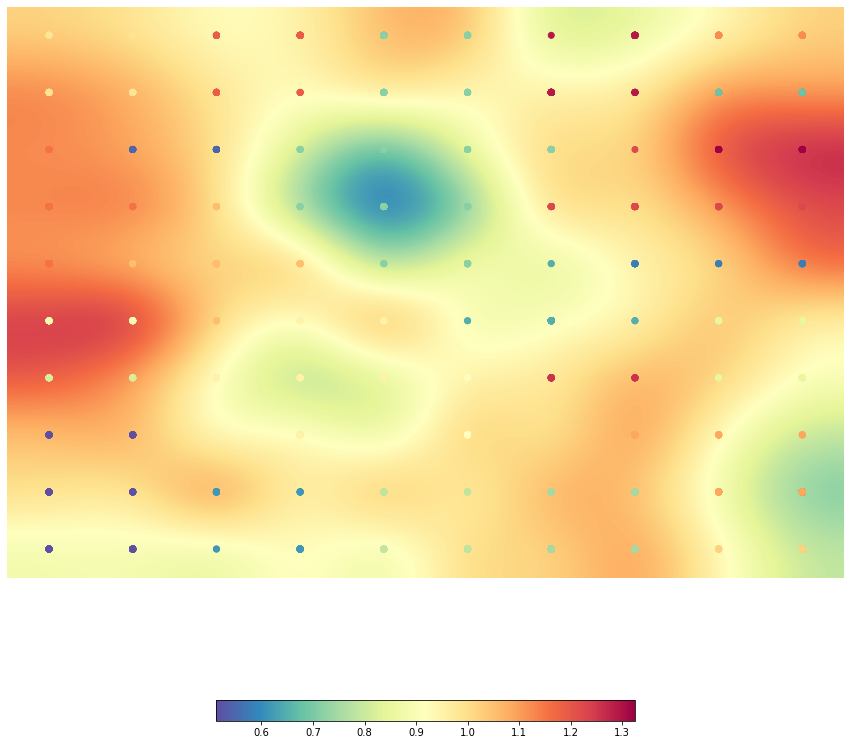

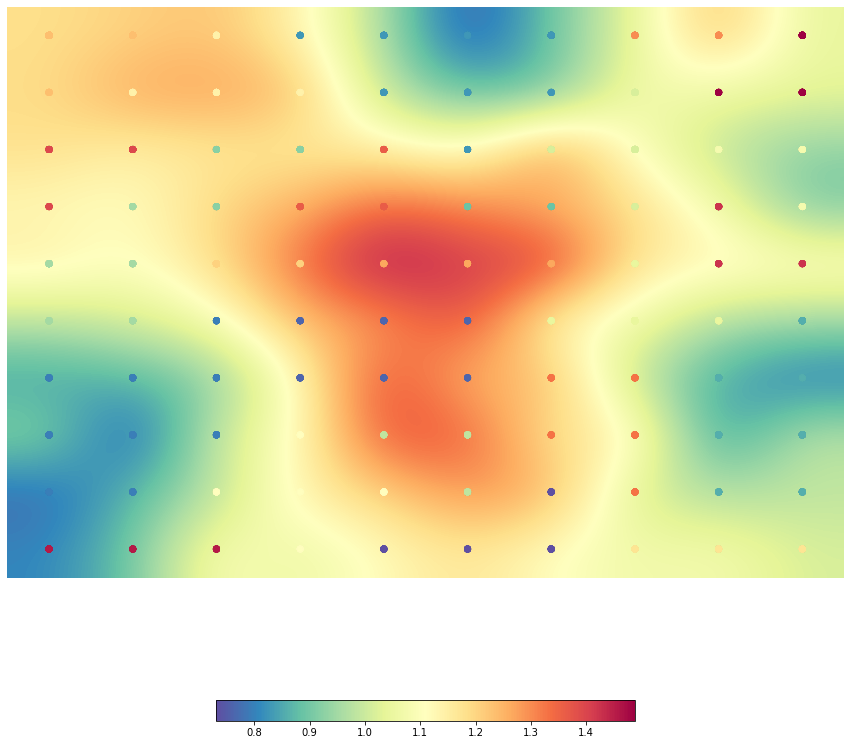

In [ ]:
## tests for 2000 movies
View_Matrix(somoclu_10_2000, 15, "K 20 & SOM 10 & MAP 15 ")
View_Matrix(somoclu_10_2000_w2v, 15, "K 20 & SOM 10 & MAP 15 ")


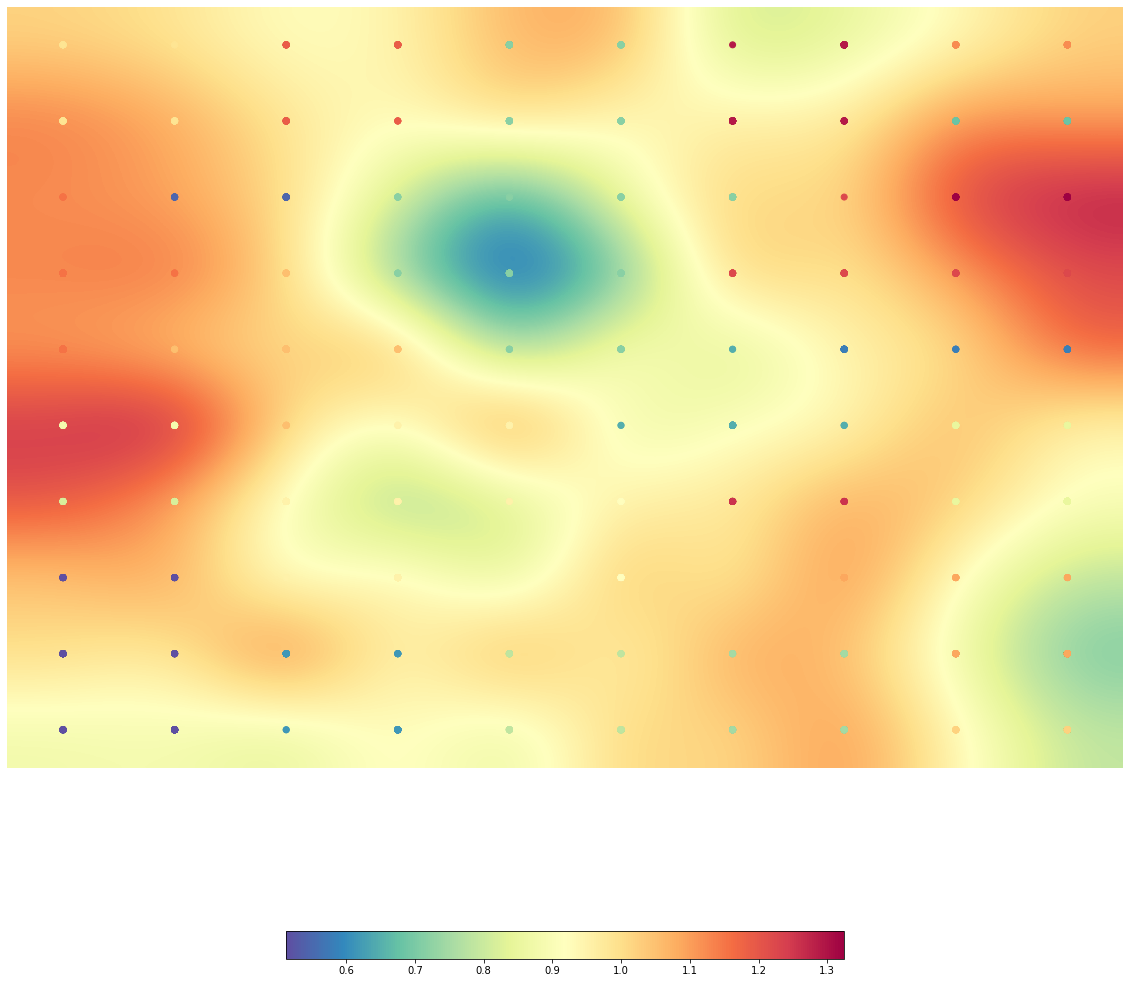

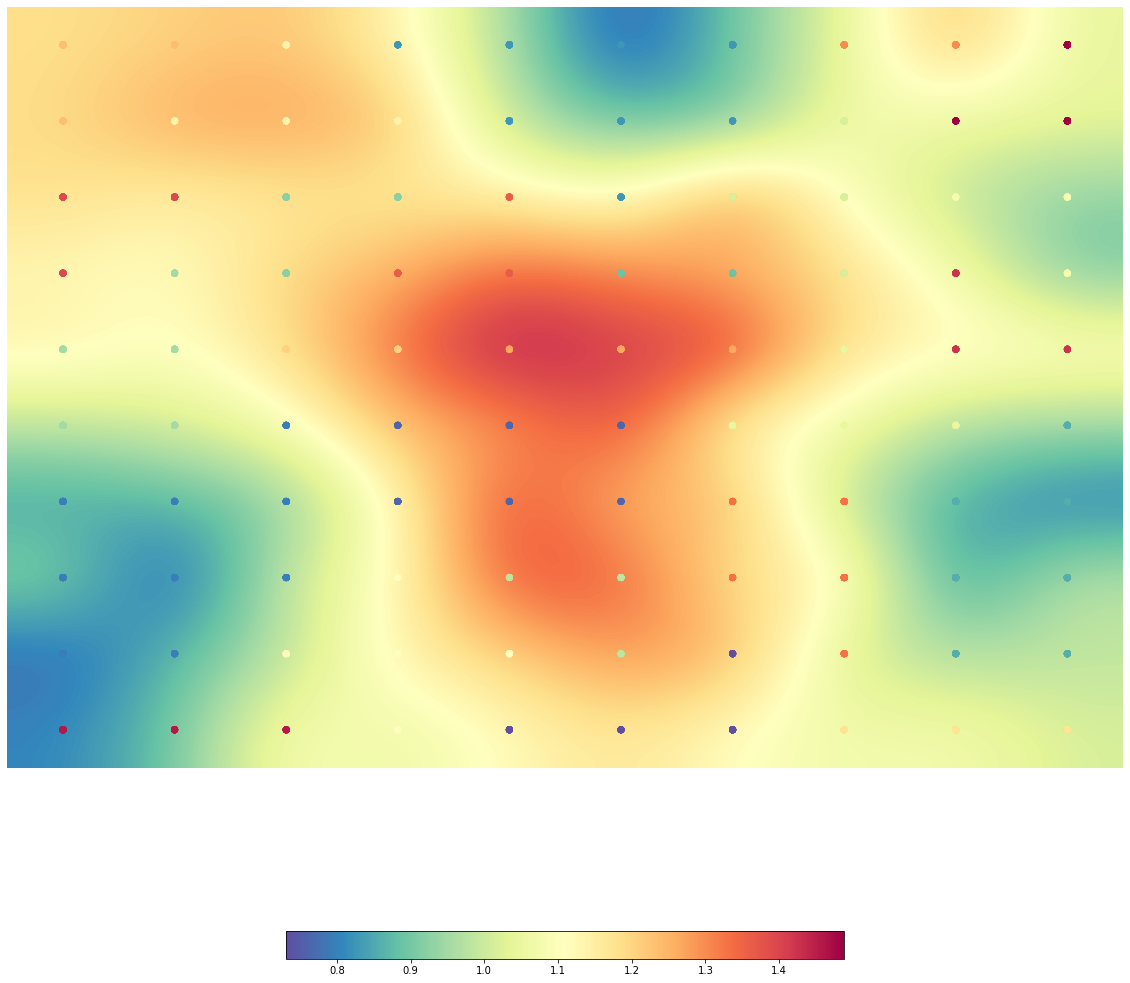

In [ ]:
View_Matrix(somoclu_10_2000, 20, "K 20 & SOM 10 & MAP 20 ")
View_Matrix(somoclu_10_2000_w2v, 20, "K 20 & SOM 10 & MAP 20 ")

Από τις παραπάνω αναπαραστάσεις φαίνεται ότι η βέλτιστη υλοποίηση είναι για word2vec, όπως και περιμέναμε.

**Για SOM (10x10) και K-means 20**

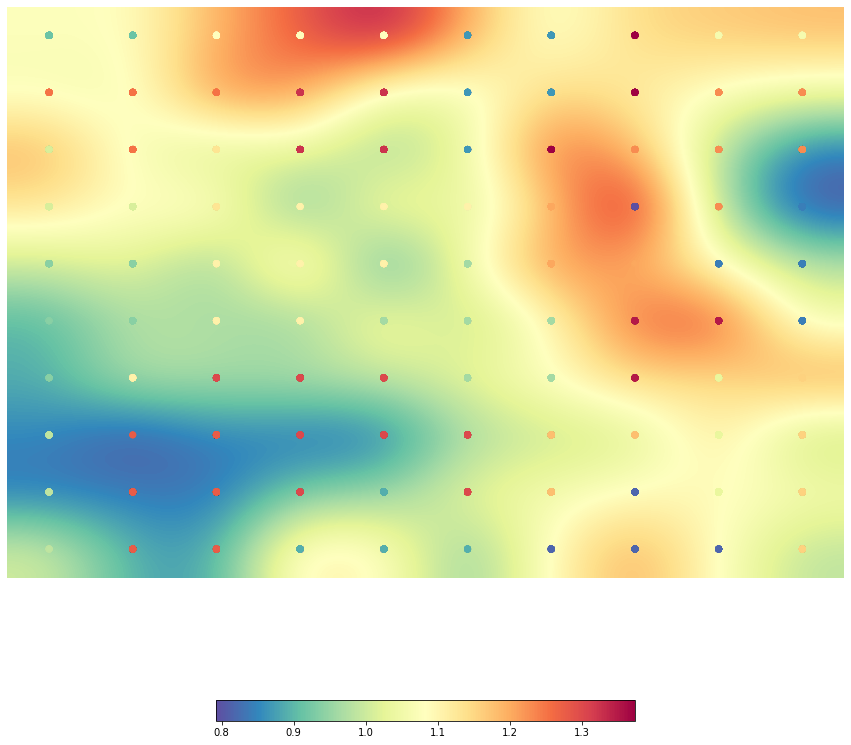

The clusters for K=20 SOM{(10x10),(100),(5000) are:
 [[ 3  3  3  2 19 19 18 18  9  9]
 [ 3 15 15  2  2  7 18 18  9  9]
 [11 11 15  2  2  7 18 16  9  9]
 [11 11 15  8  8  7  4 16  0  0]
 [12 12  8  8  8  8  4  4  0  0]
 [12 12  8  8  8 17  4  4 14  0]
 [12  8 13 13 13 17 17 14 14  6]
 [ 1  1 13 13 13 17 17 13 14  6]
 [ 1  1  1 13  5  5 13 10  6  6]
 [ 1  1  1  5  5  5 10 10 10  6]]


The neurwnes for K=20 SOM{(10x10),(100),(5000) are:
 [[19. 16.  7.  3. 15. 14. 11. 10. 17. 12.  0.  6.  5.  4.  2. 18.  9.  1.
  13.  8.]
 [ 2.  2.  3.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  6.  8.
   9. 10.]]


In [ ]:
##############################
### K=20 & SOM 10 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_20_10, 15, "K 20 & SOM 10 & MAP 15 ")
print("The clusters for K=20 SOM{(10x10),(100),(5000) are:\n",clusters_20_10)
print("\n")
print("The neurwnes for K=20 SOM{(10x10),(100),(5000) are:\n",neurwnes_20_10)

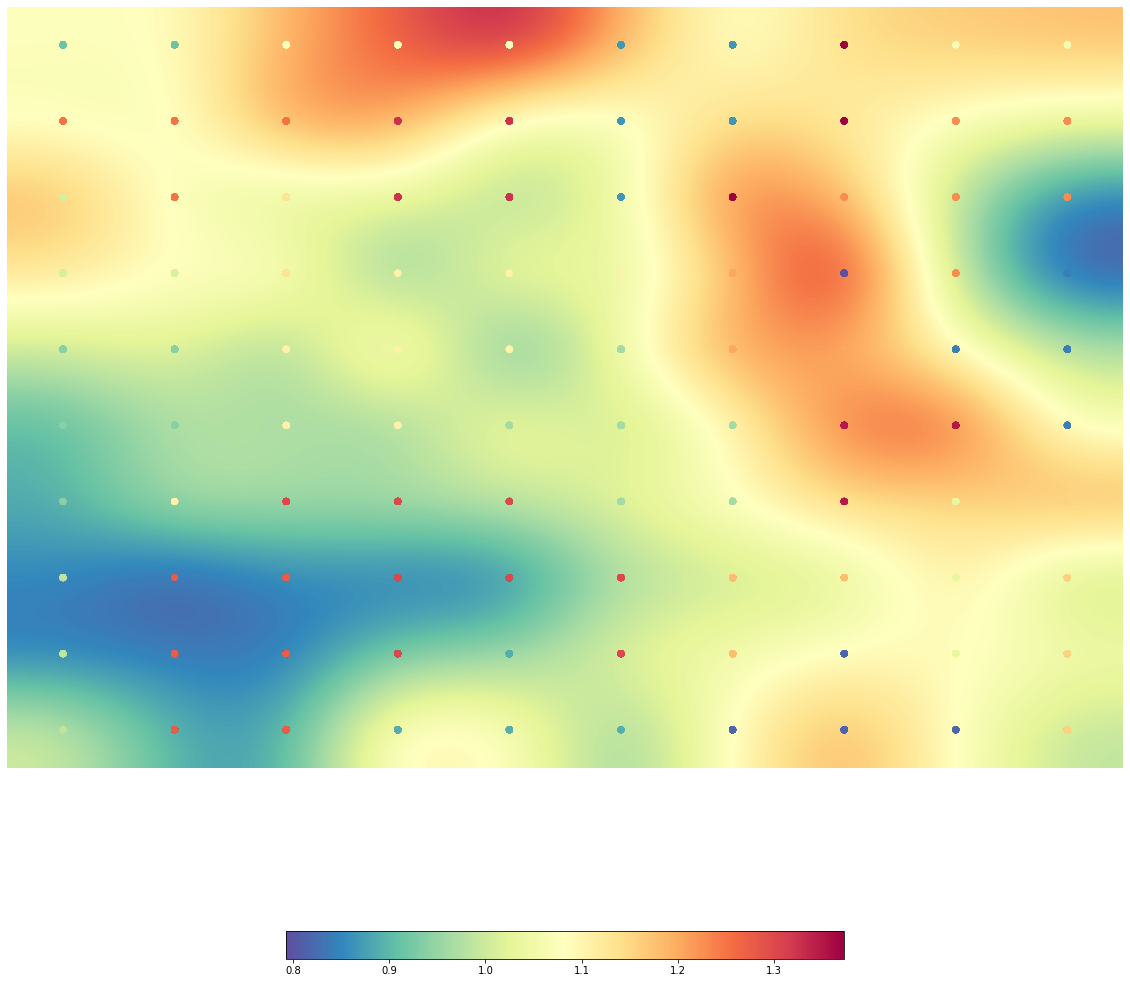

The clusters for K=20 SOM{(10x10),(100),(5000) are:
 [[ 3  3  3  2 19 19 18 18  9  9]
 [ 3 15 15  2  2  7 18 18  9  9]
 [11 11 15  2  2  7 18 16  9  9]
 [11 11 15  8  8  7  4 16  0  0]
 [12 12  8  8  8  8  4  4  0  0]
 [12 12  8  8  8 17  4  4 14  0]
 [12  8 13 13 13 17 17 14 14  6]
 [ 1  1 13 13 13 17 17 13 14  6]
 [ 1  1  1 13  5  5 13 10  6  6]
 [ 1  1  1  5  5  5 10 10 10  6]]


The neurwnes for K=20 SOM{(10x10),(100),(5000) are:
 [[19. 16.  7.  3. 15. 14. 11. 10. 17. 12.  0.  6.  5.  4.  2. 18.  9.  1.
  13.  8.]
 [ 2.  2.  3.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  6.  8.
   9. 10.]]


In [ ]:
##############################
### K=20 & SOM 10 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_20_10, 20, "K 20 & SOM 10 & MAP 20 ")
print("The clusters for K=20 SOM{(10x10),(100),(5000) are:\n",clusters_20_10)
print("\n")
print("The neurwnes for K=20 SOM{(10x10),(100),(5000) are:\n",neurwnes_20_10)

**Για SOM (10x10) και K-means 25**

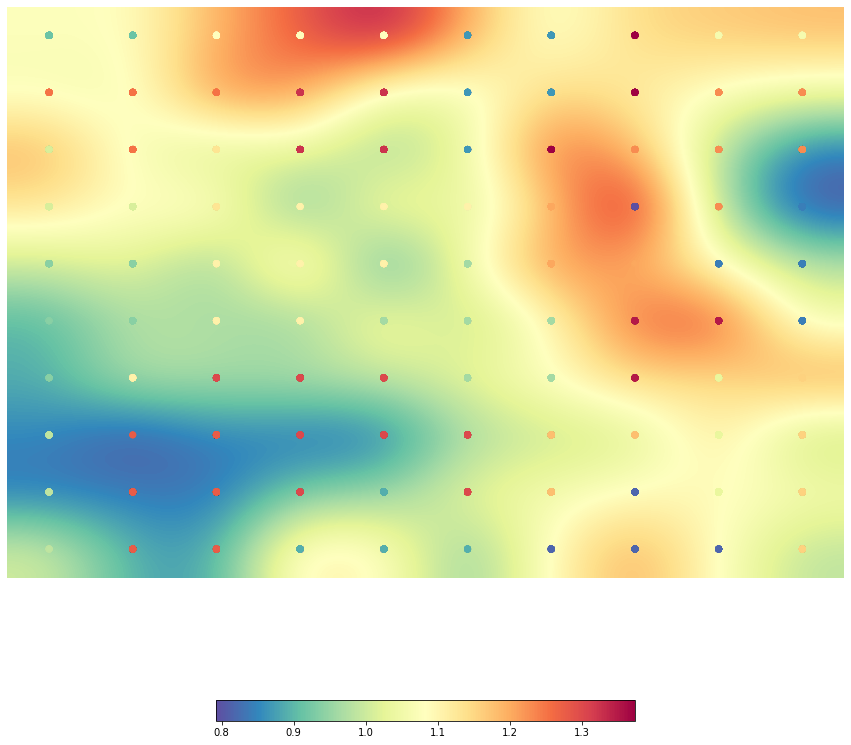

The clusters for K=20 SOM{(10x10),(100),(5000) are:
 [[ 5  5 12 12 12  3  3 24 11 11]
 [19 19 19 22 22  3  3 24 18 18]
 [ 9 19 14 22 22  3 24 18 18 18]
 [ 9  9 14 13 13 13 17  0 18  2]
 [ 6  6 13 13 13  7 17 17  2  2]
 [ 6  6 13 13  7  7  7 23 23  2]
 [ 6 13 21 21 21  7  7 23 10 15]
 [ 8 20 20 21 21 21 16 16 10 15]
 [ 8 20 20 21  4 21 16  1 10 15]
 [ 8 20 20  4  4  4  1  1  1 15]]


The neurwnes for K=20 SOM{(10x10),(100),(5000) are:
 [[ 0. 14.  5. 11. 17. 16. 23. 10.  9. 12.  8. 24.  4. 15.  2.  1. 19. 22.
   6.  3.  7. 18. 20. 21. 13.]
 [ 1.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
   5.  5.  6.  6.  6.  8.  9.]]


In [ ]:
##############################
### K=25 & SOM 10 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_25_10, 15, "K 25 & SOM 10 & MAP 15 ")
print("The clusters for K=20 SOM{(10x10),(100),(5000) are:\n",clusters_25_10)
print("\n")
print("The neurwnes for K=20 SOM{(10x10),(100),(5000) are:\n",neurwnes_25_10)

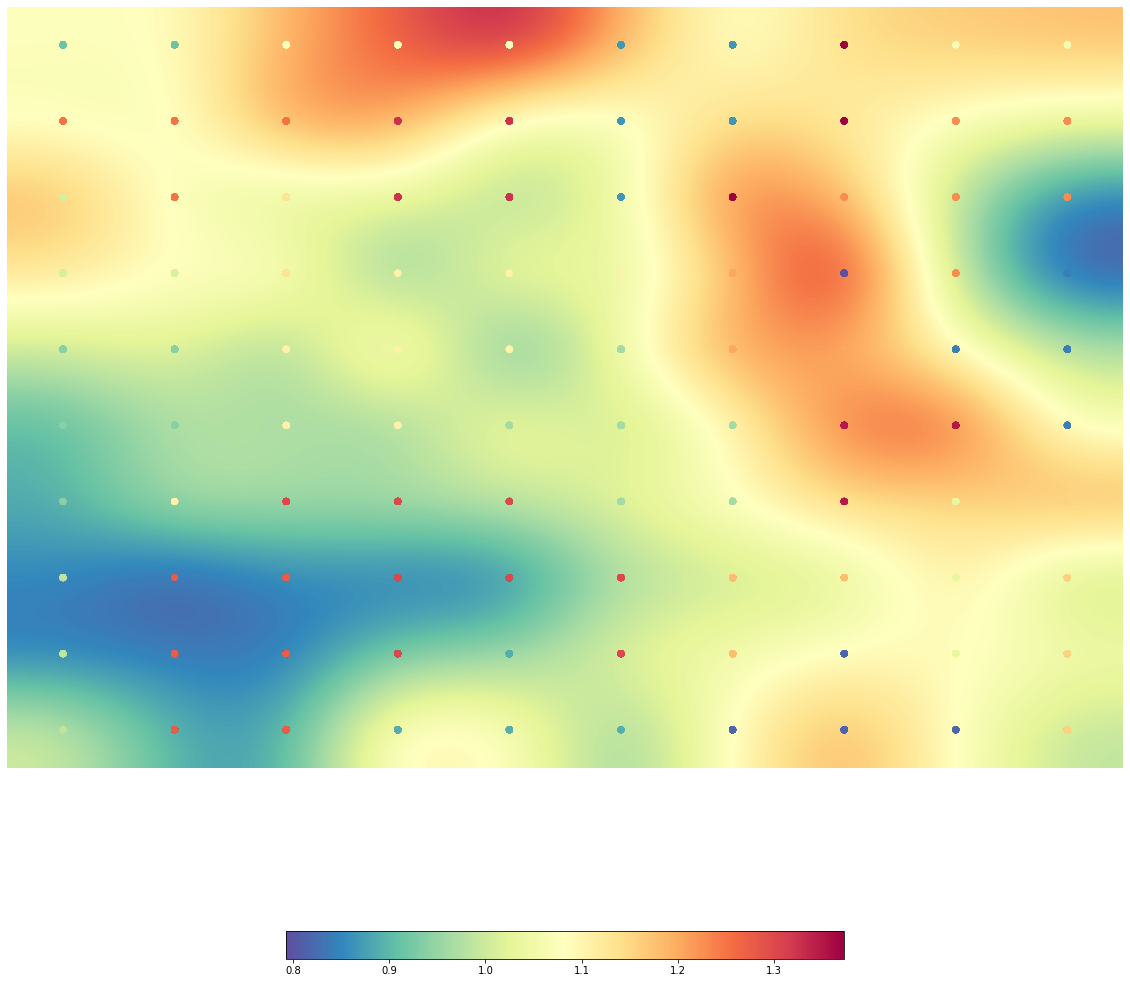

The clusters for K=20 SOM{(10x10),(100),(5000) are:
 [[ 5  5 12 12 12  3  3 24 11 11]
 [19 19 19 22 22  3  3 24 18 18]
 [ 9 19 14 22 22  3 24 18 18 18]
 [ 9  9 14 13 13 13 17  0 18  2]
 [ 6  6 13 13 13  7 17 17  2  2]
 [ 6  6 13 13  7  7  7 23 23  2]
 [ 6 13 21 21 21  7  7 23 10 15]
 [ 8 20 20 21 21 21 16 16 10 15]
 [ 8 20 20 21  4 21 16  1 10 15]
 [ 8 20 20  4  4  4  1  1  1 15]]


The neurwnes for K=20 SOM{(10x10),(100),(5000) are:
 [[ 0. 14.  5. 11. 17. 16. 23. 10.  9. 12.  8. 24.  4. 15.  2.  1. 19. 22.
   6.  3.  7. 18. 20. 21. 13.]
 [ 1.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
   5.  5.  6.  6.  6.  8.  9.]]


In [ ]:
##############################
### K=25 & SOM 10 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_25_10, 20, "K 25 & SOM 10 & MAP 20 ")
print("The clusters for K=20 SOM{(10x10),(100),(5000) are:\n",clusters_25_10)
print("\n")
print("The neurwnes for K=20 SOM{(10x10),(100),(5000) are:\n",neurwnes_25_10)

**Για SOM (20x20) και K-means 20**

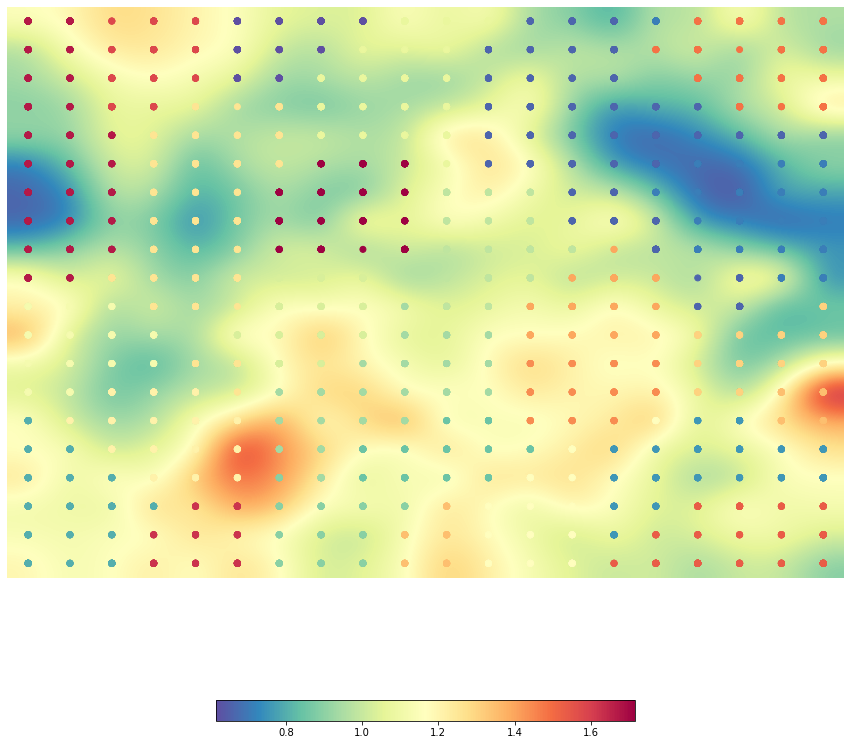

The clusters for K=20 SOM{(10x10),(100),(5000) are:
 [[ 5  5 13 13 13 13 13 13 13  3  3  2  2  2  2  4 14 14 14 14]
 [ 5  5 13 13 13 13 13 13  3  3  3  2  2  2  2  2 14 14 14 14]
 [ 5  5  5 13 13 13 13  3  3  3  3  2  2  2  2  2 14 14 14 14]
 [ 5  5  5  5 17 17 17  3  3  3  3  2  2  2  2  2  2 14  4  4]
 [ 5  5  5 17 17 17 17  3  3  3  3  3  2  2  2  2  2  4  4  4]
 [ 5  5  5 17 17 17 17 17  3  3  3  3  2  2  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17 17  3  0  0 16  4  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17 17  0  0  0 16  4  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17  0  0  0  0 16 16 16 16 16  4  4  4]
 [ 5  5 17 17 17 17 17 17  0  0  0  0 16 16 16 16 16  4  4  4]
 [11 11 11 17 17 17 17 17  0  0  0  0 16 16 16 16  2  2  4  4]
 [11 11 11 11 17 17  6  6  6  6  6  6 18 18 18 18 16  2  2  4]
 [11 11 11 11 17 17  6  6  6  6  6  6 18 18 18 18  1 19 19 19]
 [11 11 11 11 11 17  6  6  6  6  6  6  8 18 18 18  1 19 19 19]
 [ 7 11 11 11 11  6  6  6  6  6  6  8  8  8  8 10 19 19 19 19]
 [

In [ ]:
##############################
### K=20 & SOM 20 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_20_20, 15, "K 20 & SOM 20 & MAP 15 ")
print("The clusters for K=20 SOM{(10x10),(100),(5000) are:\n",clusters_20_20)
print("\n")
print("The neurwnes for K=20 SOM{(10x10),(100),(5000) are:\n",neurwnes_20_20)

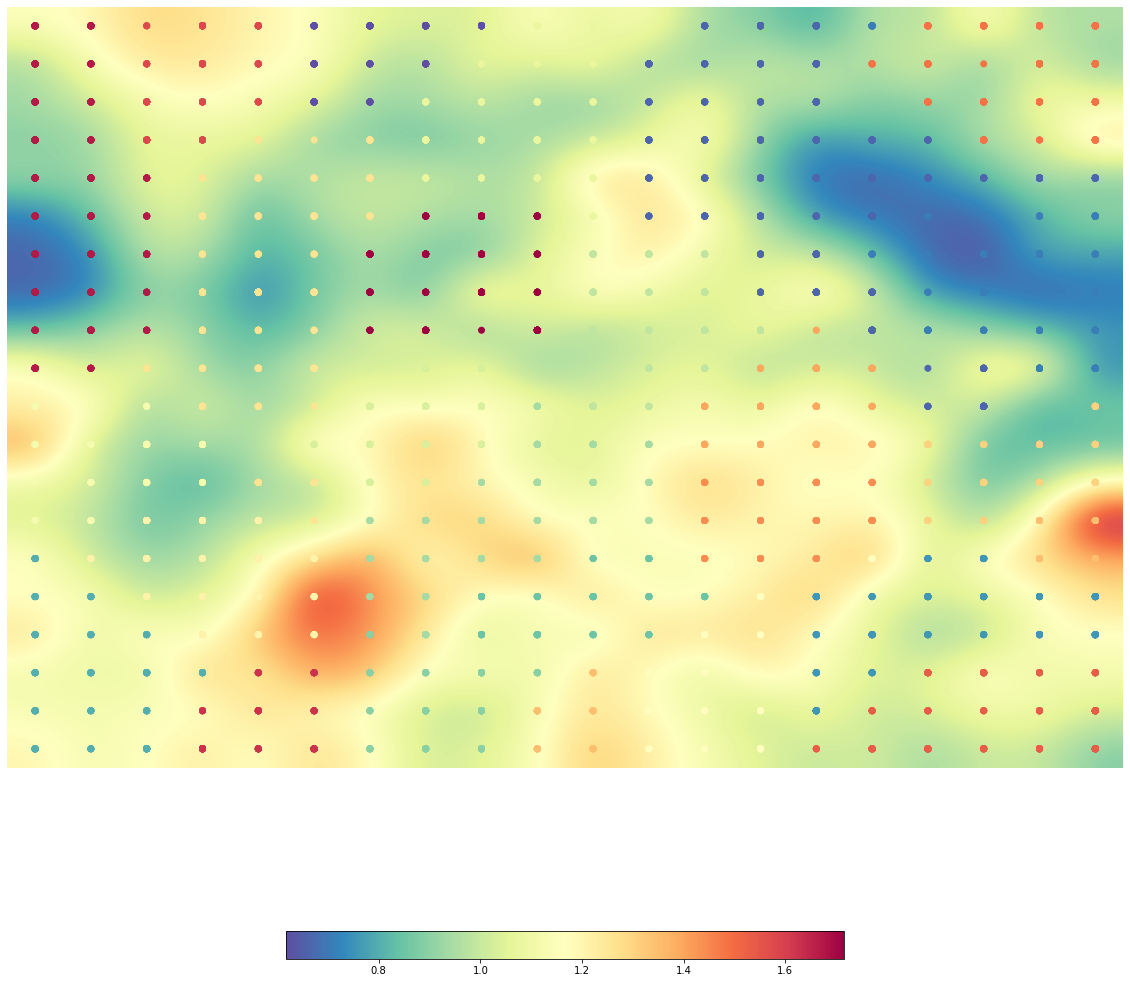

The clusters for K=20 SOM{(10x10),(100),(5000) are:
 [[ 5  5 13 13 13 13 13 13 13  3  3  2  2  2  2  4 14 14 14 14]
 [ 5  5 13 13 13 13 13 13  3  3  3  2  2  2  2  2 14 14 14 14]
 [ 5  5  5 13 13 13 13  3  3  3  3  2  2  2  2  2 14 14 14 14]
 [ 5  5  5  5 17 17 17  3  3  3  3  2  2  2  2  2  2 14  4  4]
 [ 5  5  5 17 17 17 17  3  3  3  3  3  2  2  2  2  2  4  4  4]
 [ 5  5  5 17 17 17 17 17  3  3  3  3  2  2  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17 17  3  0  0 16  4  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17 17  0  0  0 16  4  4  4  4  4  4  4]
 [ 5  5  5 17 17 17 17 17  0  0  0  0 16 16 16 16 16  4  4  4]
 [ 5  5 17 17 17 17 17 17  0  0  0  0 16 16 16 16 16  4  4  4]
 [11 11 11 17 17 17 17 17  0  0  0  0 16 16 16 16  2  2  4  4]
 [11 11 11 11 17 17  6  6  6  6  6  6 18 18 18 18 16  2  2  4]
 [11 11 11 11 17 17  6  6  6  6  6  6 18 18 18 18  1 19 19 19]
 [11 11 11 11 11 17  6  6  6  6  6  6  8 18 18 18  1 19 19 19]
 [ 7 11 11 11 11  6  6  6  6  6  6  8  8  8  8 10 19 19 19 19]
 [

In [ ]:
##############################
### K=20 & SOM 20 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_20_20, 20, "K 20 & SOM 20 & MAP 20 ")
print("The clusters for K=20 SOM{(10x10),(100),(5000) are:\n",clusters_20_20)
print("\n")
print("The neurwnes for K=20 SOM{(10x10),(100),(5000) are:\n",neurwnes_20_20)

**Για SOM (20x20) και K-means 25**

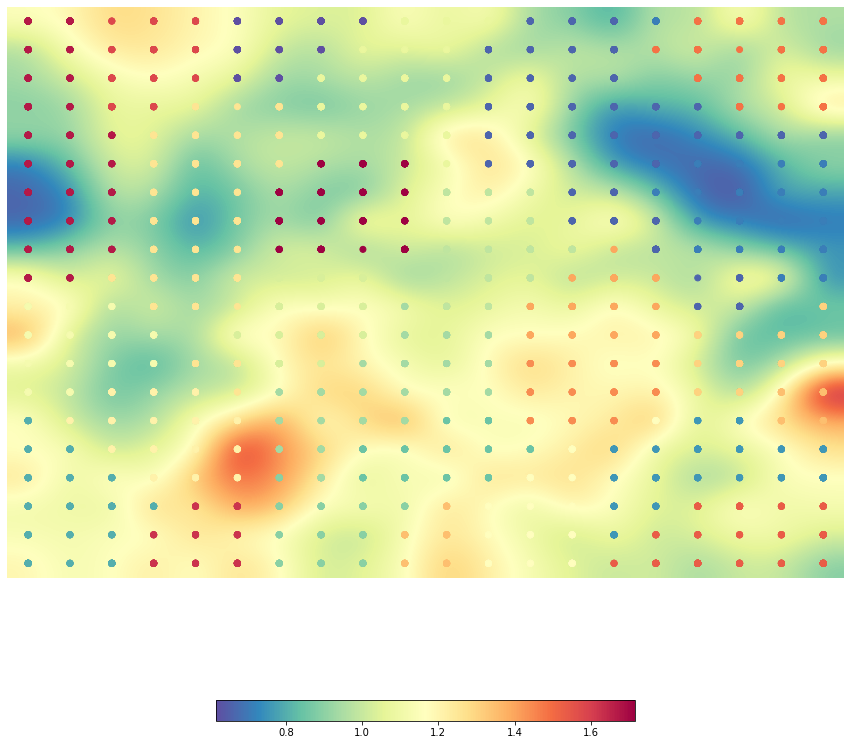

The clusters for K=25 SOM{(20x20),(100),(5000) are:
 [[23 23 21 21 21  0  0  0  0 10 10 10  1  1  1  2 19 19 19 19]
 [23 23 21 21 21  0  0  0 10 10 10  1  1  1  1 19 19 19 19 19]
 [23 23 21 21 21  0  0 10 10 10 10  1  1  1  1  1 19 19 19 19]
 [23 23 21 21 14 14 14 10 10 10 10  1  1  1  1  1  1 19 19 19]
 [23 23 23 14 14 14 14 10 10 10 10  1  1  1  1  1  1  1  1  1]
 [23 23 23 14 14 14 14 24 24 24 10  1  1  1  1  1  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  1  1  2  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  1  1  1  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  8 17  1  2  2  2  2]
 [23 23 14 14 14 14  9  9  9  8  8  8  8 17 17 17  1  1  2  2]
 [11 11 11 14 14 14  9  9  9  7  8  8 17 17 17 17  1  1 15 15]
 [11 11 11 11 14  9  9  9  9  7  7  7 17 17 17 17 15 15 15 15]
 [11 11 11 11 14 14  9  9  7  7  7  7 18 18 18 18 15 15 15 15]
 [11 11 13 13 13 14  7  7  7  7  7  7 18 18 18 18 15 15 16 16]
 [ 4 13 13 13 13 13  7  7  7  7  5  5 18 18 18 12  3  3 16 16]
 [

In [ ]:
##############################
### K=25 & SOM 20 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_25_20, 15, "K 25 & SOM 20 & MAP 15 ")
print("The clusters for K=25 SOM{(20x20),(100),(5000) are:\n",clusters_25_20)
print("\n")
print("The neurwnes for K=25 SOM{(20x20),(100),(5000) are:\n",neurwnes_25_20)

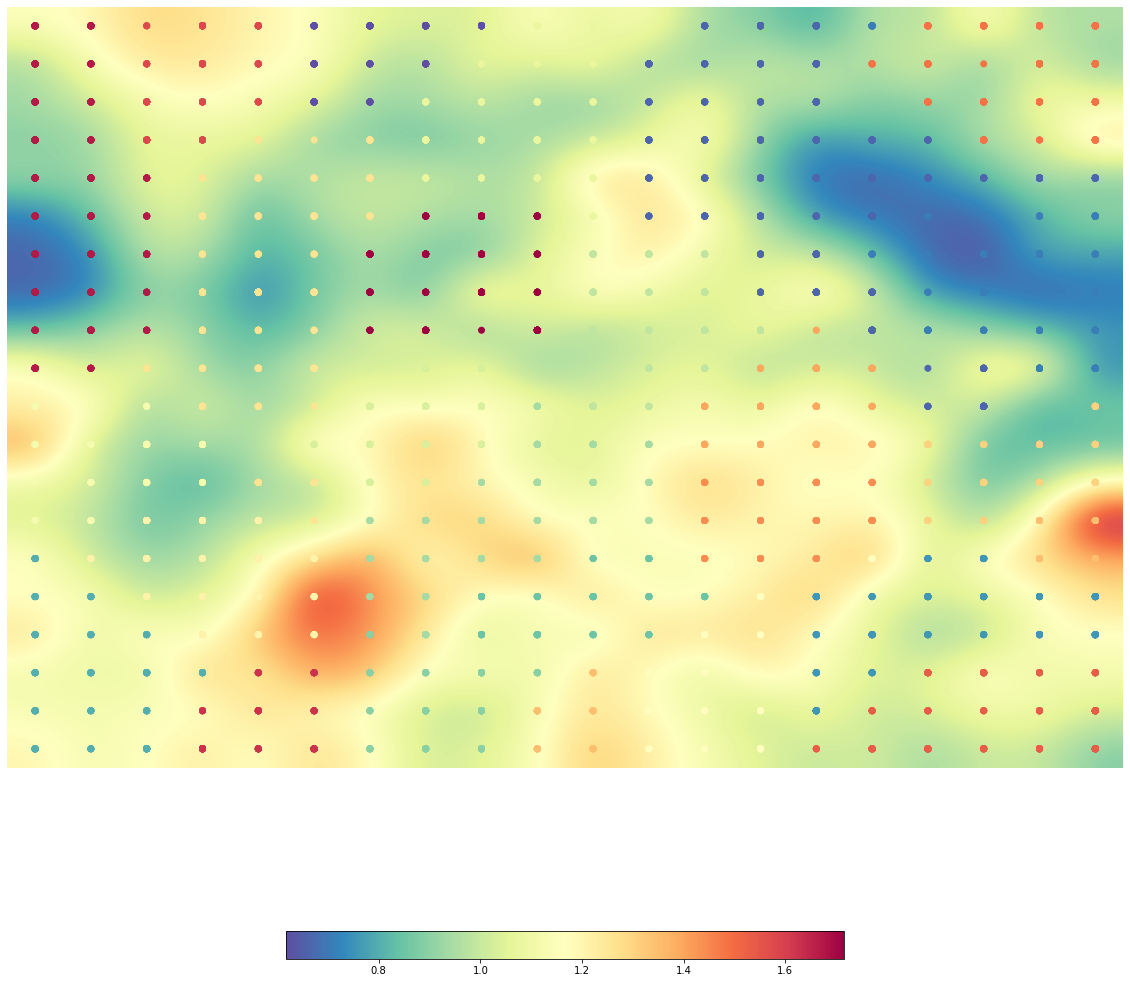

The clusters for K=25 SOM{(20x20),(100),(5000) are:
 [[23 23 21 21 21  0  0  0  0 10 10 10  1  1  1  2 19 19 19 19]
 [23 23 21 21 21  0  0  0 10 10 10  1  1  1  1 19 19 19 19 19]
 [23 23 21 21 21  0  0 10 10 10 10  1  1  1  1  1 19 19 19 19]
 [23 23 21 21 14 14 14 10 10 10 10  1  1  1  1  1  1 19 19 19]
 [23 23 23 14 14 14 14 10 10 10 10  1  1  1  1  1  1  1  1  1]
 [23 23 23 14 14 14 14 24 24 24 10  1  1  1  1  1  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  1  1  2  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  1  1  1  2  2  2  2]
 [23 23 23 14 14 14 24 24 24 24  8  8  8  8 17  1  2  2  2  2]
 [23 23 14 14 14 14  9  9  9  8  8  8  8 17 17 17  1  1  2  2]
 [11 11 11 14 14 14  9  9  9  7  8  8 17 17 17 17  1  1 15 15]
 [11 11 11 11 14  9  9  9  9  7  7  7 17 17 17 17 15 15 15 15]
 [11 11 11 11 14 14  9  9  7  7  7  7 18 18 18 18 15 15 15 15]
 [11 11 13 13 13 14  7  7  7  7  7  7 18 18 18 18 15 15 16 16]
 [ 4 13 13 13 13 13  7  7  7  7  5  5 18 18 18 12  3  3 16 16]
 [

In [ ]:
##############################
### K=25 & SOM 20 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_25_20, 20, "K 25 & SOM 20 & MAP 20 ")
print("The clusters for K=25 SOM{(20x20),(100),(5000) are:\n",clusters_25_20)
print("\n")
print("The neurwnes for K=25 SOM{(20x20),(100),(5000) are:\n",neurwnes_25_20)

**Για SOM (25x25) και K-means 20**

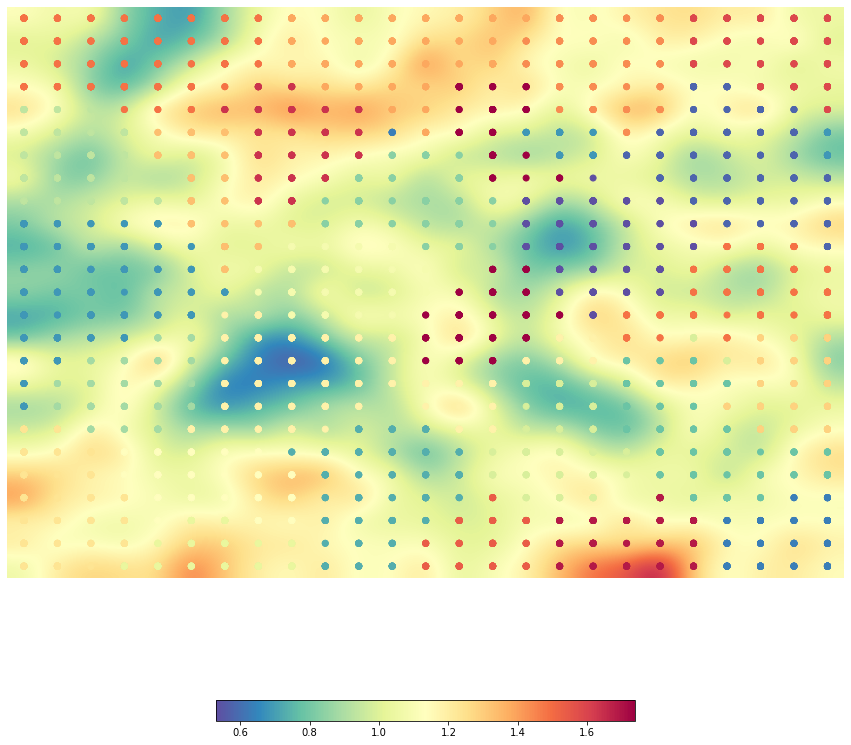

The clusters for K=20 SOM{(25x25),(100),(5000) are:
 [[ 3  3  3  3  3  3  3  3 19 19 19 19 19 19 19 19 19 19  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3  3 19 15 15 15 19 19 19 19 19 19  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3  3 15 15 15 15 15 19 19 19 19  6  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3 11 11 15 15 15 15 19 19 19  6  6  6  6 17 17 17 17
  17]
 [ 7  7  7  3  3  3 11 11 11 11 15 15 15 19 12 19 14  6  6  6  6 17 17 17
  17]
 [ 7  7  7  7  7  7  8 11 11 11 11 15 15 15 12 14 14 14  6  6 13 13 17 17
  17]
 [ 7  7  7  7  7  7  8 11 11 11 11 15 15 15 12 12 14 14 13 13 13 13 13 13
  14]
 [ 7  7  7  7  7  7  8  8 11 11  8  8 12 12 12 12 12 13 13 13 13 13 13 13
  14]
 [ 7  7  7  7  7  7  8  8  8  8  8  8 12 12 12 12 12 13 13 13 13 13 13 13
  13]
 [14 14 14 14 14  8  8  8  8  8  8  0 12 12 12 12 12 12 13 13 13 13 13 13
  13]
 [14 14 14 14 14 14  8  8  8  8  8 12 12 12 12 12 12 12 12 13 13 13  3  3
  13]
 [14 14 14 14 14 14  8 14  0 12 12 12 12 12 12 12 12 12 12  3  3  3

In [ ]:
##############################
### K=20 & SOM 25 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_20_25, 15, "K 20 & SOM 25 & MAP 15 ")
print("The clusters for K=20 SOM{(25x25),(100),(5000) are:\n",clusters_20_25)
print("\n")
print("The neurwnes for K=20 SOM{(25x25),(100),(5000) are:\n",neurwnes_20_25)

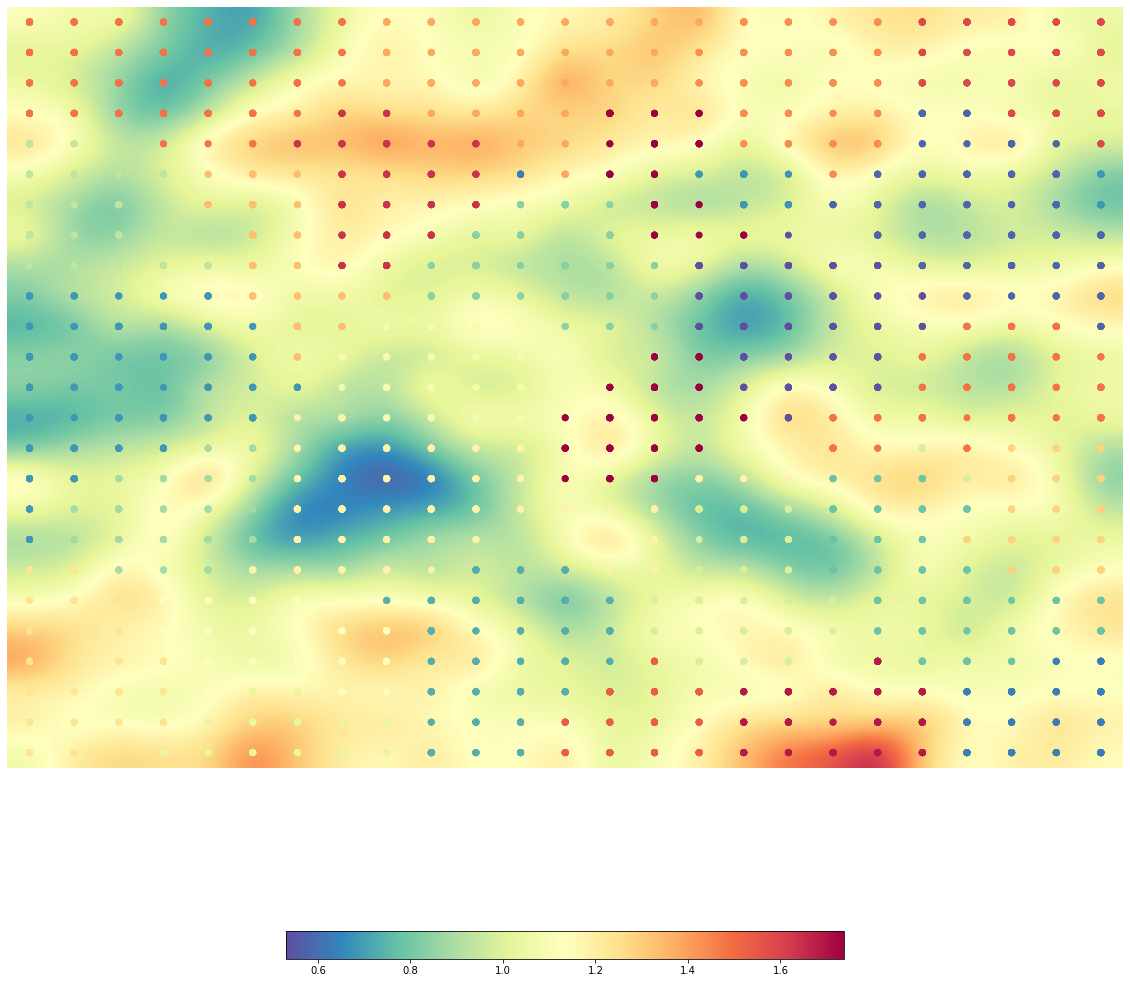

The clusters for K=20 SOM{(25x25),(100),(5000) are:
 [[ 3  3  3  3  3  3  3  3 19 19 19 19 19 19 19 19 19 19  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3  3 19 15 15 15 19 19 19 19 19 19  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3  3 15 15 15 15 15 19 19 19 19  6  6  6  6 17 17 17
  17]
 [ 3  3  3  3  3  3  3 11 11 15 15 15 15 19 19 19  6  6  6  6 17 17 17 17
  17]
 [ 7  7  7  3  3  3 11 11 11 11 15 15 15 19 12 19 14  6  6  6  6 17 17 17
  17]
 [ 7  7  7  7  7  7  8 11 11 11 11 15 15 15 12 14 14 14  6  6 13 13 17 17
  17]
 [ 7  7  7  7  7  7  8 11 11 11 11 15 15 15 12 12 14 14 13 13 13 13 13 13
  14]
 [ 7  7  7  7  7  7  8  8 11 11  8  8 12 12 12 12 12 13 13 13 13 13 13 13
  14]
 [ 7  7  7  7  7  7  8  8  8  8  8  8 12 12 12 12 12 13 13 13 13 13 13 13
  13]
 [14 14 14 14 14  8  8  8  8  8  8  0 12 12 12 12 12 12 13 13 13 13 13 13
  13]
 [14 14 14 14 14 14  8  8  8  8  8 12 12 12 12 12 12 12 12 13 13 13  3  3
  13]
 [14 14 14 14 14 14  8 14  0 12 12 12 12 12 12 12 12 12 12  3  3  3

In [ ]:
##############################
### K=20 & SOM 25 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_20_25, 20, "K 20 & SOM 25 & MAP 20 ")
print("The clusters for K=20 SOM{(25x25),(100),(5000) are:\n",clusters_20_25)
print("\n")
print("The neurwnes for K=20 SOM{(25x25),(100),(5000) are:\n",neurwnes_20_25)

**Για SOM (25x25) και K-means 25**

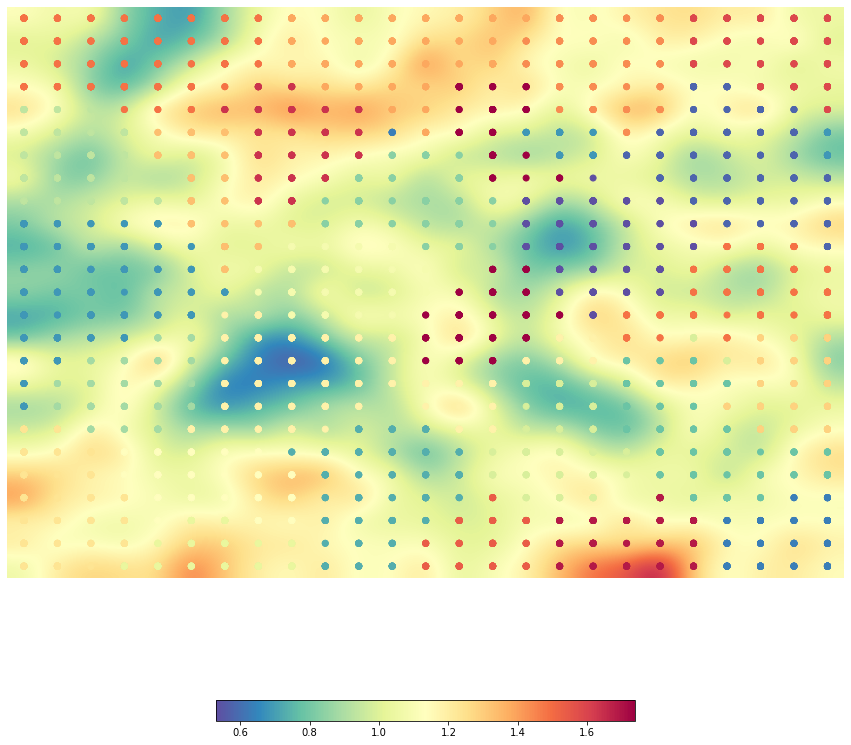

The clusters for K=25 SOM{(25x25),(100),(5000) are:
 [[19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 17 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 18 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 18 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 22 22 17 17 17 17 24 24 24 18 18 18 18  1  1 21 21
  21]
 [ 8  8  8 19 19 19 22 22 22 22 22 17 17 24 24 24 18 18 18 18  1  1  1  1
  21]
 [ 8  8  8  8 16 16 16 22 22 22 22  2 17 24 24  3  3  3 18  1  1  1  1  1
   3]
 [ 8  8  8  8 16 16 16 22 22 22 22  6  6  6 24 24  3  3  1  1  1  1  1  1
   3]
 [ 8  8  8  8 16 16 16 22 22 22  6  6  6  6 24 24 24  0  0  1  1  1  1  1
   1]
 [ 8  8  8  8  8 16 16 22 22  6  6  6  6  6  6  0  0  0  0  0  1  1  1  1
   1]
 [ 3  3  3  3  3 16 16 16 16  6  6  6  6  6  6  0  0  0  0  0  0  1  1  1
   1]
 [ 3  3  3  3  3  3 16 16 11 11 11 11  6  6  6  0  0  0  0  0  0 19 19 19
   1]
 [ 3  3  3  3  3  3 16 11 11 11 11 11 11 24 24 24  0  0  0  0 19 19

In [ ]:
##############################
### K=25 & SOM 25 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_25_25, 15, "K 25 & SOM 25 & MAP 15 ")
print("The clusters for K=25 SOM{(25x25),(100),(5000) are:\n",clusters_25_25)
print("\n")
print("The neurwnes for K=25 SOM{(25x25),(100),(5000) are:\n",neurwnes_25_25)

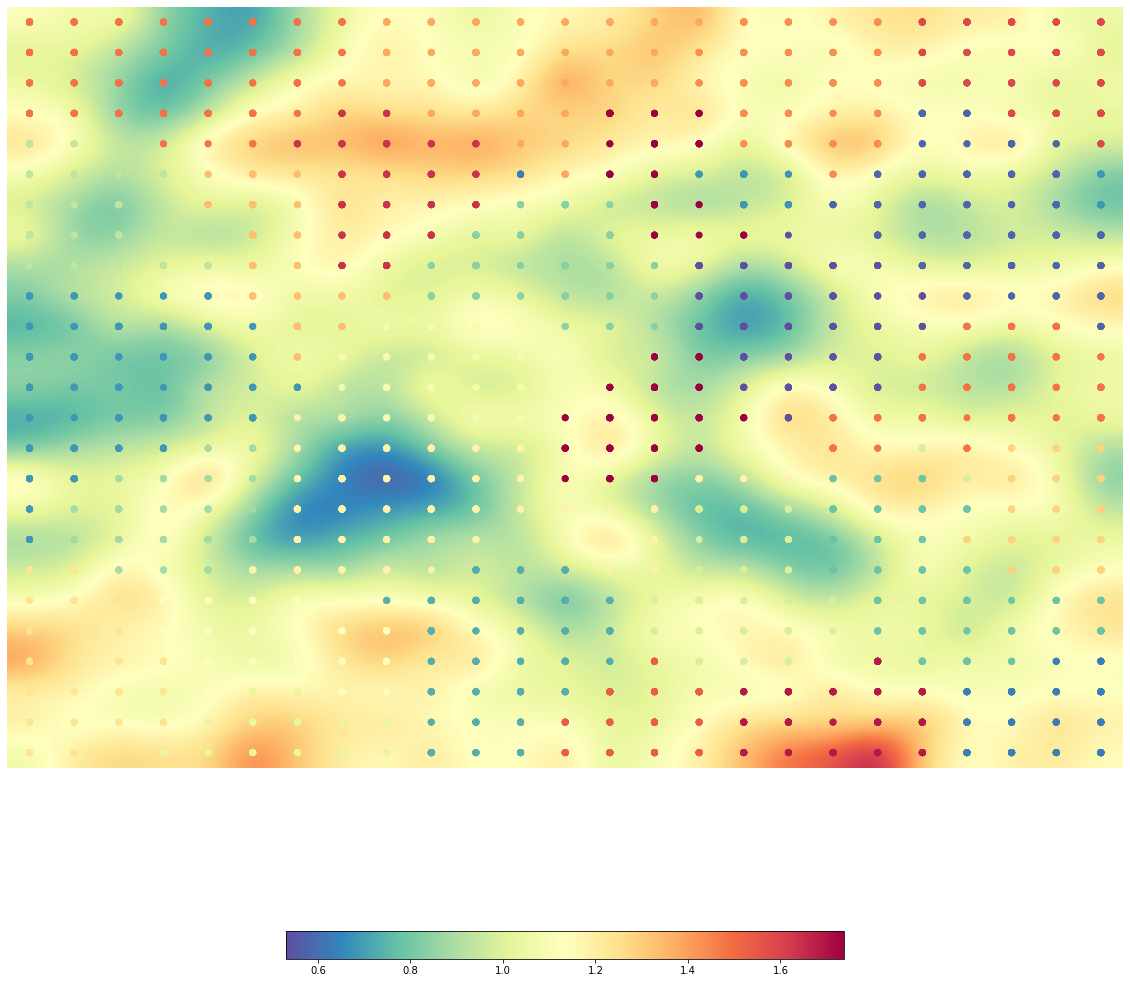

The clusters for K=25 SOM{(25x25),(100),(5000) are:
 [[19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 17 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 18 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 19 17 17 17 17 17 17 17 18 18 18 18 18 21 21 21 21
  21]
 [19 19 19 19 19 19 19 22 22 17 17 17 17 24 24 24 18 18 18 18  1  1 21 21
  21]
 [ 8  8  8 19 19 19 22 22 22 22 22 17 17 24 24 24 18 18 18 18  1  1  1  1
  21]
 [ 8  8  8  8 16 16 16 22 22 22 22  2 17 24 24  3  3  3 18  1  1  1  1  1
   3]
 [ 8  8  8  8 16 16 16 22 22 22 22  6  6  6 24 24  3  3  1  1  1  1  1  1
   3]
 [ 8  8  8  8 16 16 16 22 22 22  6  6  6  6 24 24 24  0  0  1  1  1  1  1
   1]
 [ 8  8  8  8  8 16 16 22 22  6  6  6  6  6  6  0  0  0  0  0  1  1  1  1
   1]
 [ 3  3  3  3  3 16 16 16 16  6  6  6  6  6  6  0  0  0  0  0  0  1  1  1
   1]
 [ 3  3  3  3  3  3 16 16 11 11 11 11  6  6  6  0  0  0  0  0  0 19 19 19
   1]
 [ 3  3  3  3  3  3 16 11 11 11 11 11 11 24 24 24  0  0  0  0 19 19

In [ ]:
##############################
### K=25 & SOM 25 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_25_25, 20, "K 25 & SOM 25 & MAP 20 ")
print("The clusters for K=25 SOM{(25x25),(100),(5000) are:\n",clusters_25_25)
print("\n")
print("The neurwnes for K=25 SOM{(25x25),(100),(5000) are:\n",neurwnes_25_25)

**Για SOM (30x30) και K-means 20**

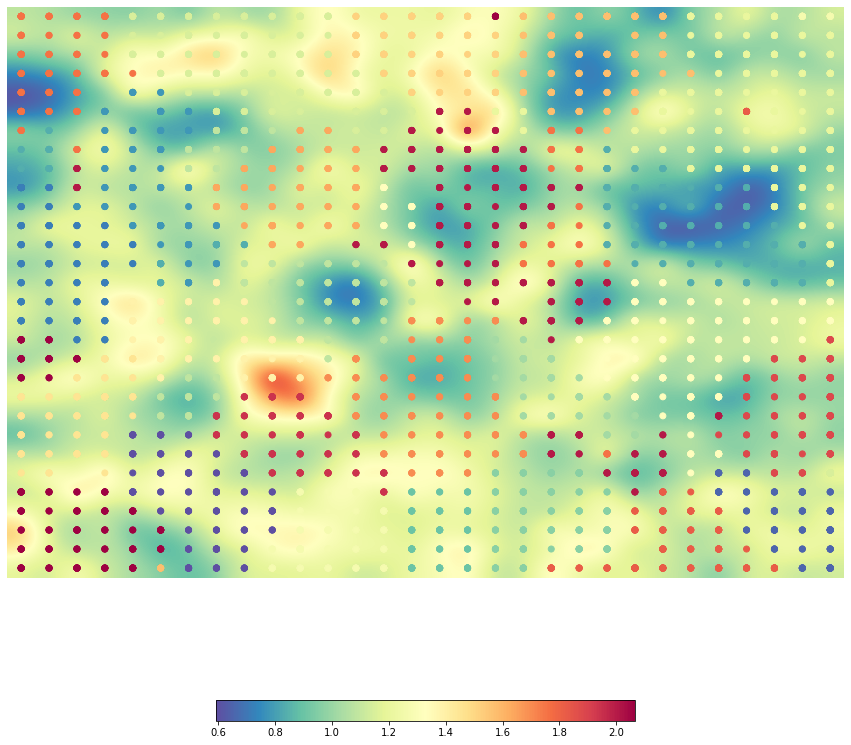

The clusters for K=20 SOM{(30x30),(100),(5000) are:
 [[ 4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13 13  3  3  3 12 12
  12 12  5  5  5  5]
 [ 4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13 13  3  3  3  3 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13  3  3 12 12 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  7  7  7  7  7  7  7  7 13 13 13 13 13 13  1 12 12 12 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  2  7  7  7  7  7  7  7  7  7 13 13  1  1  1 12 12 12 12
  12 12  1  5  5  5]
 [ 4  4  4  2  2  2  2  7  7  7  7  7  7  7  7  7  1  1  1  1  1  1 12 12
   1  1  1  1  1  1]
 [ 4 12  4  2  2  2  2  2  2  7  7  7  7  7  7 18 18  1  1  1  4  1 12  1
   1  1  1  1  1  1]
 [12 12 18  2  2  2  2  2  2 19 19 19 19  7 18 18 18 18 18  4  4 12 12 12
   1  1  1  1  1  1]
 [12 12 18  2  2  2  2  2 19 19 19 19 19 17 18 18 18 18 18  4  4 12 12 12
  12  1  1  1  1  1]
 [ 9  9 18  2  2  2  2 19 19 19 19 19 19 17 17 18 18 18 18 18 18 12 12 12
  12 12 12 12  1  

In [ ]:
##############################
### K=20 & SOM 30 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_20_30, 15, "K 20 & SOM 30 & MAP 15 ")
print("The clusters for K=20 SOM{(30x30),(100),(5000) are:\n",clusters_20_30)
print("\n")
print("The neurwnes for K=20 SOM{(30x30),(100),(5000) are:\n",neurwnes_20_30)

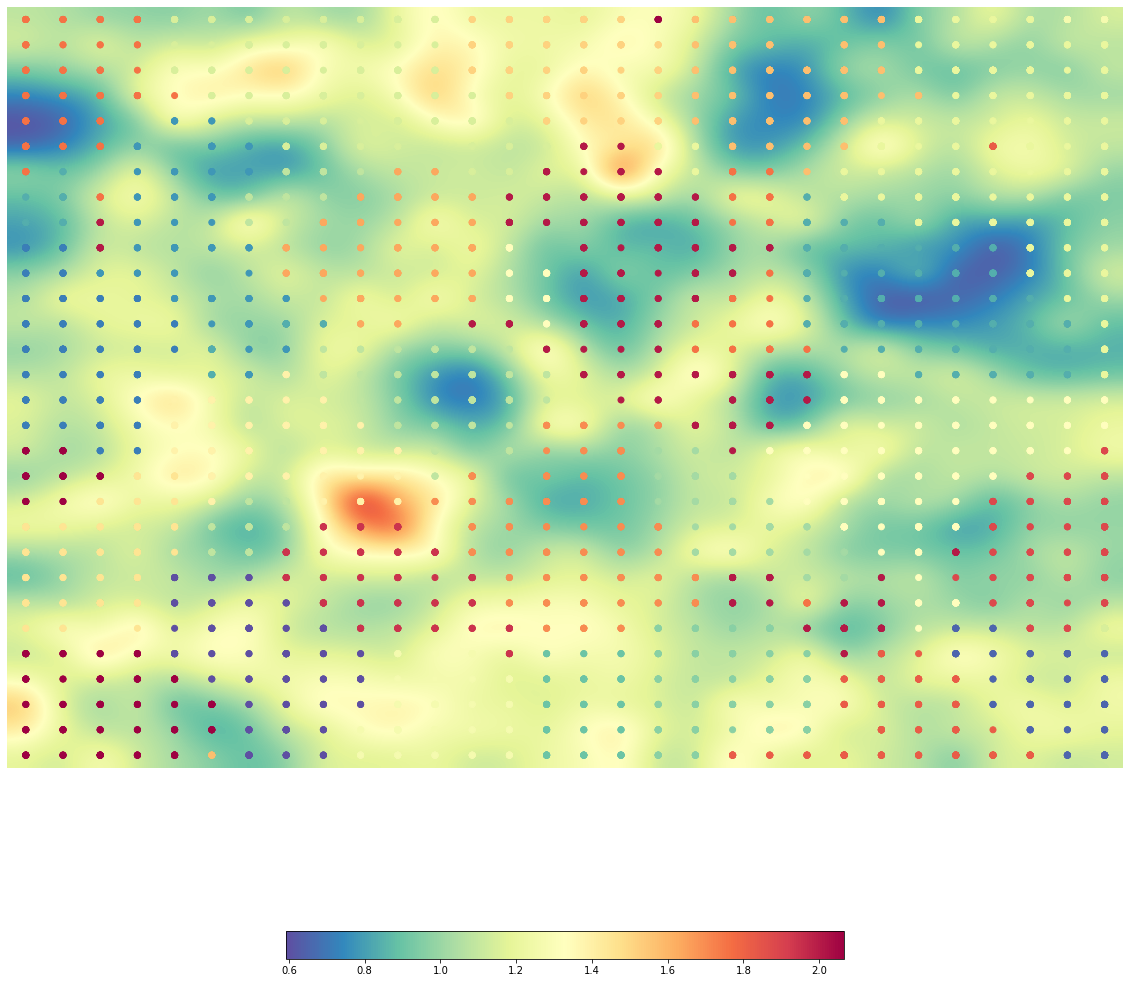

The clusters for K=20 SOM{(30x30),(100),(5000) are:
 [[ 4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13 13  3  3  3 12 12
  12 12  5  5  5  5]
 [ 4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13 13  3  3  3  3 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  7  7  7  7  7  7  7 13 13 13 13 13 13 13  3  3 12 12 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  7  7  7  7  7  7  7  7 13 13 13 13 13 13  1 12 12 12 12
  12 12 12  5  5  5]
 [ 4  4  4  4  4  2  7  7  7  7  7  7  7  7  7 13 13  1  1  1 12 12 12 12
  12 12  1  5  5  5]
 [ 4  4  4  2  2  2  2  7  7  7  7  7  7  7  7  7  1  1  1  1  1  1 12 12
   1  1  1  1  1  1]
 [ 4 12  4  2  2  2  2  2  2  7  7  7  7  7  7 18 18  1  1  1  4  1 12  1
   1  1  1  1  1  1]
 [12 12 18  2  2  2  2  2  2 19 19 19 19  7 18 18 18 18 18  4  4 12 12 12
   1  1  1  1  1  1]
 [12 12 18  2  2  2  2  2 19 19 19 19 19 17 18 18 18 18 18  4  4 12 12 12
  12  1  1  1  1  1]
 [ 9  9 18  2  2  2  2 19 19 19 19 19 19 17 17 18 18 18 18 18 18 12 12 12
  12 12 12 12  1  

In [ ]:
##############################
### K=20 & SOM 30 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_20_30, 20, "K 20 & SOM 30 & MAP 20 ")
print("The clusters for K=20 SOM{(30x30),(100),(5000) are:\n",clusters_20_30)
print("\n")
print("The neurwnes for K=20 SOM{(30x30),(100),(5000) are:\n",neurwnes_20_30)

**Για SOM (30x30) και K-means 25**

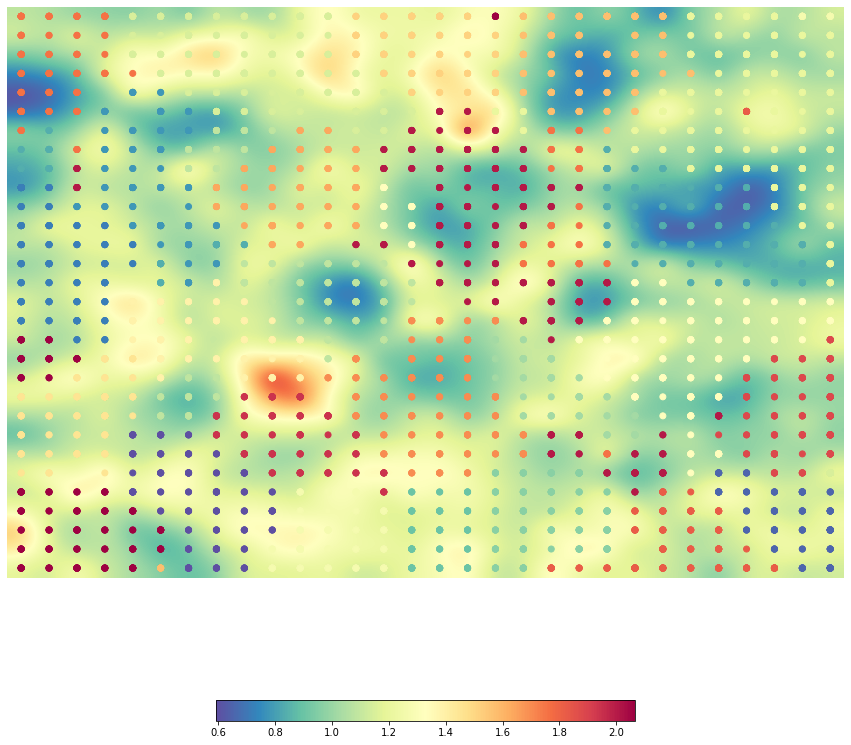

The clusters for K=25 SOM{(30x30),(100),(5000) are:
 [[19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 24 16 16 16 16 16 16
  10 10 10 10 11 11]
 [19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 15 16 16 16 16 16 16
  10 10 10 10 10 10]
 [19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 15 16 16 16 16 16 16
  10 10 10 10 10 10]
 [19 19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 16 16 16 16 16 16
  16 10 10 10 10 10]
 [19 19 19 19  3  3  9  9  9  9  9  9  9  9 15 15 15 15 16 16 16 16 16 10
  10 10 10 10 10 10]
 [19 19 19  3  3  3  3  9  9  9  9  9  9  9  9 23 23 10 10 16 16 16 16 10
  10 10 20 10 10 10]
 [19  4 19  3  3  3  3  8  8  8 17 17  9  9 23 23 23 23 10 19 19 16 10 10
  10 10 10 10 10 10]
 [ 4  4 19  3  3  3  8  8  8 17 17 17 17 23 23 23 23 23 23 19 19  4 10 10
  10 10 10 10 10 10]
 [ 4  4 23  3  3  3  8  8 17 17 17 17 17 23 23 23 23 23 23 19 19  4  4  4
  10 10 10 10 10 10]
 [ 2  2 23  3  3  3  3 17 17 17 17 17 17 12 12 23 23 23 23 23 23  4  4  4
   4  4  4 10 10 1

In [ ]:
#############################
### K=25 & SOM 30 & MAP 15 ###
##############################

View_Matrix(somocli_clustered_25_30, 15, "K 25 & SOM 30 & MAP 15 ")
print("The clusters for K=25 SOM{(30x30),(100),(5000) are:\n",clusters_25_30)
print("\n")
print("The neurwnes for K=25 SOM{(30x30),(100),(5000) are:\n",neurwnes_25_30)

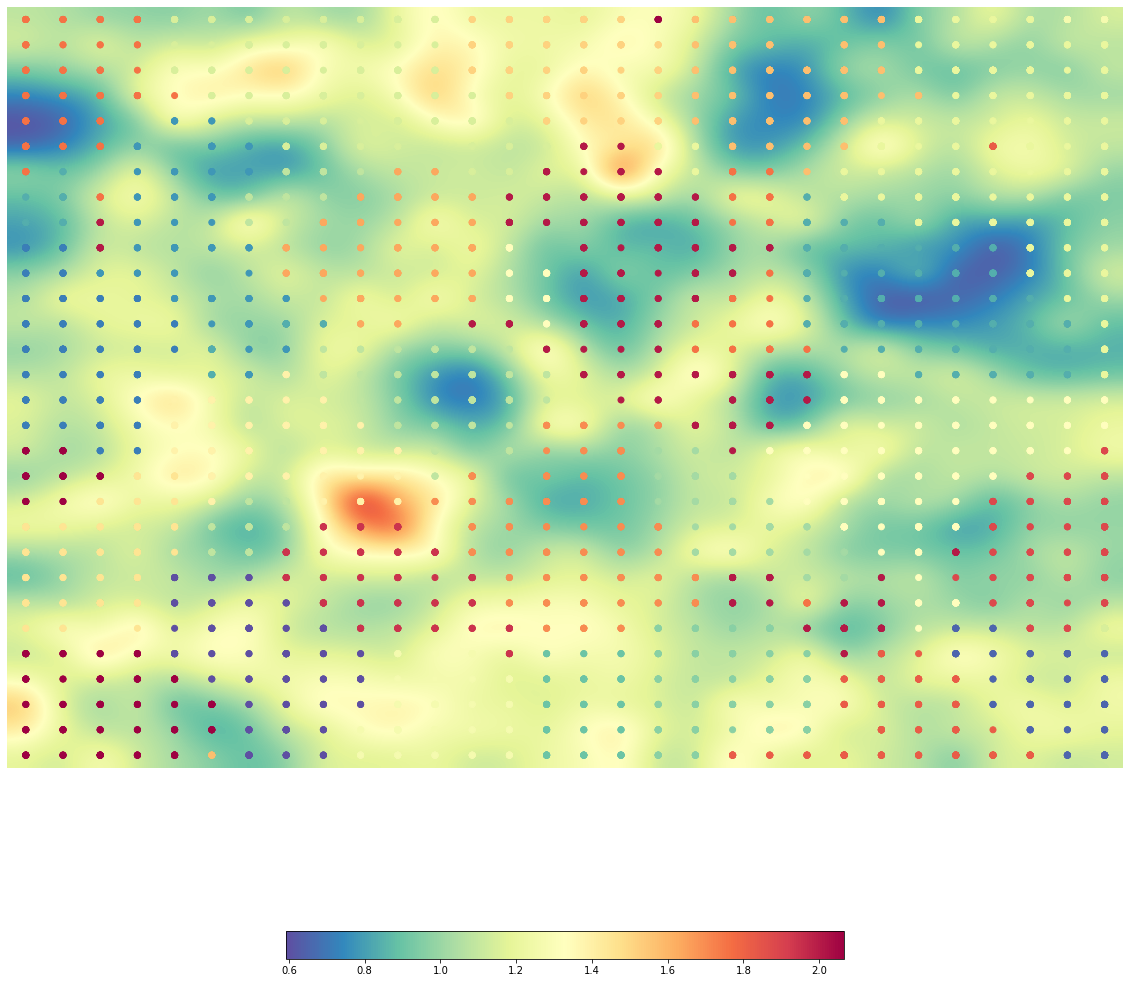

The clusters for K=25 SOM{(30x30),(100),(5000) are:
 [[19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 24 16 16 16 16 16 16
  10 10 10 10 11 11]
 [19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 15 16 16 16 16 16 16
  10 10 10 10 10 10]
 [19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 15 16 16 16 16 16 16
  10 10 10 10 10 10]
 [19 19 19 19 19  9  9  9  9  9  9  9  9 15 15 15 15 15 16 16 16 16 16 16
  16 10 10 10 10 10]
 [19 19 19 19  3  3  9  9  9  9  9  9  9  9 15 15 15 15 16 16 16 16 16 10
  10 10 10 10 10 10]
 [19 19 19  3  3  3  3  9  9  9  9  9  9  9  9 23 23 10 10 16 16 16 16 10
  10 10 20 10 10 10]
 [19  4 19  3  3  3  3  8  8  8 17 17  9  9 23 23 23 23 10 19 19 16 10 10
  10 10 10 10 10 10]
 [ 4  4 19  3  3  3  8  8  8 17 17 17 17 23 23 23 23 23 23 19 19  4 10 10
  10 10 10 10 10 10]
 [ 4  4 23  3  3  3  8  8 17 17 17 17 17 23 23 23 23 23 23 19 19  4  4  4
  10 10 10 10 10 10]
 [ 2  2 23  3  3  3  3 17 17 17 17 17 17 12 12 23 23 23 23 23 23  4  4  4
   4  4  4 10 10 1

In [ ]:
##############################
### K=25 & SOM 30 & MAP 20 ###
##############################

View_Matrix(somocli_clustered_25_30, 20, "K 25 & SOM 30 & MAP 20 ")
print("The clusters for K=25 SOM{(30x30),(100),(5000) are:\n",clusters_25_30)
print("\n")
print("The neurwnes for K=25 SOM{(30x30),(100),(5000) are:\n",neurwnes_25_30)


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

**Συνάρτηση print_categories_stats** 

Αυτή η συνάρτηση δέχεται ως όρισμα μια λίστα από ids ενός πλήθους ταινιών και επιστρέφει μια λίστα από τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένές κατά φθίνουσα σειρά εμφάνισης.

In [ ]:
def print_categories_stats(ids_tainiwn):
  total_categories_helper = []
  for id in ids_tainiwn:
    category_helper = [category.strip(" ").strip('"') for category in categories[id][0].split(",")]
    total_categories_helper.extend(category_helper)
    
  categories_uniq, categories_freq = np.unique(total_categories_helper, return_counts=True)
    
  categories_freq_min2max = np.argsort(categories_freq)
  categories_freq_max2min = categories_freq_min2max[::-1]
    
  total_categories = [(categories_uniq[index],categories_freq[index]) for index in categories_freq_max2min]
  
  print("The categories stats are:")
  print(total_categories)
  return total_categories

In [ ]:
total_categories = print_categories_stats([999, 18, 4135, 3560, 516])

#Check if OK ? 
#print("The length of the is:",len(total_categories))
#print("The categories stats is:",total_categories)

The categories stats are:
[('World cinema', 3), ('Drama', 3), ('Romance Film', 2), ('Musical', 2), ('Family Film', 2), ('Comedy', 2), ('Animation', 2), ('Short Film', 1), ('Romantic drama', 1), ('Filipino Movies', 1), ('Bollywood', 1)]


**Συνάρτηση print_cluster_neurons_movies_report**

Αυτή η συνάρτηση δέχεται ως ορίσματα το id ενός cluster και μια κλάση τύπου somoclu και επιστρέφει τις συντεταγμένες των bmus που αντιστοιχούν στο id του cluster σε ένα πίνακα, και μια λίστα όπου για κάθε bmu που υπάρχει στον πίνακα μοναδικών bmus, που έχουμε υπολογίσει στην αρχή συνολικά, προστίθεται το αντίστοιχο index του νευρώνα. 

In [ ]:
def print_cluster_neurons_movies_report(cluster_id, somocli):
  # find bmus coordinates
  bmus_coor_yx = np.where(somocli.clusters==cluster_id)
  # (column,row) --> (row,column)
  bmus_coor = bmus_coor_yx[::-1]
  #create the cluster array
  cluster_bmus = np.column_stack(bmus_coor)
  neurons_list = []
  for clust_bmu in cluster_bmus:
    for indICE, som_bmu in enumerate(somocli.bmus):
      elegxos = np.array_equal(clust_bmu, som_bmu)
      if (elegxos):
        neurons_list.append(indICE)
  
  return cluster_bmus, neurons_list

In [ ]:
cb_my, l_my = print_cluster_neurons_movies_report(7,somocli_clustered_20_10)
print(cb_my,"\n",l_my)

**Συνάρτηση neuron_movies_report**

Αυτή η συνάρτηση έχει ως είσοδο ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες.

In [ ]:
def neuron_movies_report(neurwnes, somocli):
  movies_per_neurons = []
  for neurwna in neurwnes:
    for indICE, som_bmu in enumerate(somocli.bmus):
      elegxos = np.array_equal(neurwna, som_bmu)
      if (elegxos):
        movies_per_neurons.append(indICE)
  
  
  return movies_per_neurons

In [ ]:
ids_mov = neuron_movies_report(cb_my, somocli_clustered_20_10)
print(len(ids_mov))

234


In [ ]:
def meaning_cluster_231(cluster_id, somocli):
  #
  print("Cluster:"+str(cluster_id))
  
  #call 2
  neurwnes_coor,neurwnes_list = print_cluster_neurons_movies_report(cluster_id, somocli)
  
  #call 3
  ids_movies = neuron_movies_report(neurwnes_coor,somocli)
  
  #call 1
  print_categories_stats(ids_movies)
  
  double_diaxorisi()
  return None  

In [ ]:
meaning_cluster_231(0, somocli_clustered_20_10)

Cluster:0
The categories stats are:
[('Short Film', 57), ('Black-and-white', 54), ('Comedy', 49), ('Silent film', 27), ('Indie', 20), ('Slapstick', 15), ('Family Film', 9), ('Surrealism', 1), ('Drama', 1), ('Crime Comedy', 1), ('Documentary', 1), ('Fantasy', 1), ('Experimental film', 1), ('Film noir', 1), ('Propaganda film', 1), ('Romance Film', 1), ('Avant-garde', 1)]
*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*
*-------------------------------------------------* *-------------------------------------------------* *-------------------------------------------------*


**Για SOM 10x10 K-means 20**

In [ ]:
for k in range(20):
  meaning_cluster_231(k, somocli_clustered_20_10)
  


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


In [ ]:
def uniq_category_finder(Categories):
  categories_helper = []
  for i in range(0,len(Categories)):
    category_helper = [category.strip(" ").strip('"') for category in Categories[i][0].split(",")]
    categories_helper.extend(category_helper)
    
  categories_uniq = np.unique(categories_helper)
  return categories_uniq




In [ ]:
categories_uniq = uniq_category_finder(categories)

In [ ]:
def stats_category_per_neuro(column, row, somocli):
  
  katigories_neurwnes = []                                                   
  for stili in range(column):  
    for grammi in range(row):                                                         
       aidis_mov = neuron_movies_report([[stili,grammi]],somocli)                   
       categories_stats = print_categories_stats(aidis_mov)     
       katigories_neurwnes.extend(categories_stats)              

  return katigories_neurwnes

In [ ]:
category_stats_per_neuro = stats_category_per_neuro(10, 10, somocli_clustered_20_10)

In [ ]:
print(category_stats_per_neuro[1][0])

Romance Film


In [ ]:
def neurons_per_category(category, stats_cat_per_neuro):
    neuro = 0                                                                     
    for i in range(0,len(stats_cat_per_neuro)):                                    
      if(stats_cat_per_neuro[i][0] == category):                                                       
        neuro+=1                                                               
    return neuro  



In [ ]:
neurons_per_category('Comedy', category_stats_per_neuro)

73

In [ ]:
Categories_Preference_helper = []
for catego in categories_uniq:
  Categories_Preference_helper2 = neurons_per_category(catego, category_stats_per_neuro)
  Categories_Preference_helper.append((catego,Categories_Preference_helper2))


Categories_Preference_min2max = sorted(Categories_Preference_helper, key=lambda x: x[1])
Categories_Preference = Categories_Preference_min2max[::-1]
print(Categories_Preference)

[('Indie', 84), ('Black-and-white', 77), ('Romance Film', 75), ('Comedy', 73), ('Action', 73), ('Drama', 72), ('Musical', 71), ('Adventure', 71), ('World cinema', 70), ('Crime Fiction', 70), ('Thriller', 69), ('Fantasy', 69), ('Science Fiction', 67), ('Family Film', 66), ('Mystery', 62), ('Comedy film', 57), ('Action/Adventure', 56), ('Horror', 55), ('War film', 53), ('Film adaptation', 53), ('Chinese Movies', 53), ('Comedy-drama', 51), ('Period piece', 50), ('Western', 49), ('Television movie', 49), ('Silent film', 48), ('Short Film', 46), ('Japanese Movies', 43), ('Sports', 40), ('Black comedy', 39), ('Biographical film', 38), ('Teen', 36), ('Bollywood', 36), ('Animation', 36), ('Romantic comedy', 35), ('Coming of age', 34), ('Satire', 33), ('Psychological thriller', 33), ('Family Drama', 33), ("Children's/Family", 33), ('Political drama', 31), ('Parody', 31), ('Road movie', 30), ('Melodrama', 29), ('Biography', 29), ('Romantic drama', 28), ('Music', 28), ('Costume drama', 28), ('Ens

In [ ]:
# Translation dictionaries for table alignment
left_rule = {'<': ':', '^': ':', '>': '-'}
right_rule = {'<': '-', '^': ':', '>': ':'}

def evalute_field(record, field_spec):
    """
    Evalute a field of a record using the type of the field_spec as a guide.
    """
    if type(field_spec) is int:
        return str(record[field_spec])
    elif type(field_spec) is str:
        return str(getattr(record, field_spec))
    else:
        return str(field_spec(record))

def table(file, records, fields, headings, alignment = None):
    num_columns = len(fields)
    assert len(headings) == num_columns

    # Compute the table cell data
    columns = [[] for i in range(num_columns)]
    for record in records:
        for i, field in enumerate(fields):
            columns[i].append(evalute_field(record, field))

    # Fill out any missing alignment characters.
    extended_align = alignment if alignment != None else []
    if len(extended_align) > num_columns:
        extended_align = extended_align[0:num_columns]
    elif len(extended_align) < num_columns:
        extended_align += [('^', '<')
                           for i in range[num_columns-len(extended_align)]]

    heading_align, cell_align = [x for x in zip(*extended_align)]

    field_widths = [len(max(column, key=len)) if len(column) > 0 else 0
                    for column in columns]
    heading_widths = [max(len(head), 2) for head in headings]
    column_widths = [max(x) for x in zip(field_widths, heading_widths)]

    _ = ' | '.join(['{:' + a + str(w) + '}'
                    for a, w in zip(heading_align, column_widths)])
    heading_template = '| ' + _ + ' |'
    _ = ' | '.join(['{:' + a + str(w) + '}'
                    for a, w in zip(cell_align, column_widths)])
    row_template = '| ' + _ + ' |'

    _ = ' | '.join([left_rule[a] + '-'*(w-2) + right_rule[a]
                    for a, w in zip(cell_align, column_widths)])
    ruling = '| ' + _ + ' |'

    file.write(heading_template.format(*headings).rstrip() + '\n')
    file.write(ruling.rstrip() + '\n')
    for row in zip(*columns):
        file.write(row_template.format(*row).rstrip() + '\n')

    return None 

def markdownCreator(titlos,epikefalides,dedomena):
  
  sys.stdout.write(titlos+'\n\n')

  fields = np.ndarray.tolist(np.arange(len(epikefalides)))

  align = [('^', '<'), ('^', '^'), ('^', '<'), ('^', '^'), ('^', '>'),('^','^')]

  table(sys.stdout, dedomena, fields, epikefalides, align)

  return None

In [ ]:
titlos_mark1 = ' ' 
epikefalides_mark1 = []
dedomena_mark1 = [(),
                  (),
                  ]
                  
markdownCreator(titlos_mark1, epikefalides_mark1, dedomena_mark1)